* * * * * * * * * * *
Master notebook to run every step of the analyses of the Z0 experiment in python.

Author: Rodrigo Guedes Lang (rodrigo.lang@fau.de)

Date: March 2024

Based on scripts by Kathrin Valerius and Jannik Hofestaedt from 2011-2013
* * * * * * * * * * *

In [304]:
from glob import glob
from natsort import natsorted
import uproot
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.constants as constants

In [2]:
from PIL import Image
from IPython.display import display

import ipywidgets as widgets
from ipywidgets import interact

import random

In [3]:
def browse_images(channel):
    images = natsorted(glob(f'../Data/GROPEScreenshots/{channel}/*.png'))
    def view_image(i):
        display(Image.open(images[i]))
    interact(view_image, i=(0,len(images)-1))

def pick_images(samples = None):
    if samples is None:
        n = random.sample(range(0,40), k=10)
    else:
        n = samples
    
    images = natsorted(glob(f'../Data/GROPEScreenshots/test/*.png'))
    def view_image(i):
        display(Image.open(images[i]))
    interact(view_image, i=n)
    print(n)

# Part 1 - Qualitative analysis of events

In this part of the experiment, the main idea is to look at a small subset of Monte Carlo (MC) events to build up insight on how events from each channel look like on average. The final good is to come up with some crude cuts to separate the channels.

## Part 1.1 - GROPE event display

### Exercises

- 1.1. For each channel, describe qualitatively the features of its events.

- 1.2. Come up with a 4x4 table describing which variables are important for separating each pair of channels

In [193]:
browse_images(["ee", "mm", "tt", "qq"][0])

interactive(children=(IntSlider(value=9, description='i', max=19), Output()), _dom_classes=('widget-interact',…

In [5]:
from IPython.display import display, Markdown

In [6]:
code = r""" \usepackage{tabularx}

\begin{tabel}
\centering

\begin{tabular}{c|c|c|c}
$e^+ e^-$ & $\mu^- \mu^+$ & $\tau^- \tau^+$ & $q \overline{q}$ 
\end{tabular}
\end{table}"""


# LaTeX table
table = r"""
\begin{array}{c|c|c|c}
\hline
 & e^+ e^- & \mu^- \mu^+ & \tau^- \tau^+ & q \overline{q} \\
\hline
e^+ e^- & -- & ECAL_E > 30 & Sum_p > 80 or ECAL_E > 80 & Ctrk_N < 10\\
\mu^+ \mu^- & HCAL_E > 1 & -- & Sum_p > 80 or ECAL_E + HCAL_E < 20 & Ctrk_N < 10\\
\tau^+ \tau^- & HCAL_E > 1 & Sum_P < 70 & -- & Ctrk_N < 10\\
q \overline{q} & HCAL_E > 1 & Ctrk_N > 2 & Ctrk_N > 10 or ECAL_E + HCAL_E >70 & -- \\
\hline
\end{array}
"""

print("criteria for exclusion:")
print("Particle Guess -> first row; if any condition in column is valid, guess is wrong.")
display(Markdown(table))
print("e+e-: necessary condition : ECAL_E > 30")

criteria for exclusion:
Particle Guess -> first row; if any condition in column is valid, guess is wrong.



\begin{array}{c|c|c|c}
\hline
 & e^+ e^- & \mu^- \mu^+ & \tau^- \tau^+ & q \overline{q} \\
\hline
e^+ e^- & -- & ECAL_E > 30 & Sum_p > 80 or ECAL_E > 80 & Ctrk_N < 10\\
\mu^+ \mu^- & HCAL_E > 1 & -- & Sum_p > 80 or ECAL_E + HCAL_E < 20 & Ctrk_N < 10\\
\tau^+ \tau^- & HCAL_E > 1 & Sum_P < 70 & -- & Ctrk_N < 10\\
q \overline{q} & HCAL_E > 1 & Ctrk_N > 2 & Ctrk_N > 10 or ECAL_E + HCAL_E >70 & -- \\
\hline
\end{array}


e+e-: necessary condition : ECAL_E > 30


- 1.3. Now, for 10 randomly selected images, just by looking at the GROPE image, try to evaluate what channel each event originates from (ee, mm, tt or qq).

random picture identification:
29: e+ e-
35: t+ t- 
32: t+ t-
21: q aq
13: e+ e-
12: q aq
34: mu+ mu-
16: mu+ mu- 
28: low energy e+ e-
38: low energy e+ e-

In [7]:
pick_images(np.array([29, 35, 32, 21, 13, 12, 34, 16, 28, 38]))

interactive(children=(Dropdown(description='i', options=(29, 35, 32, 21, 13, 12, 34, 16, 28, 38), value=29), O…

[29 35 32 21 13 12 34 16 28 38]


In [8]:
code = r""" \usepackage{tabularx}

\begin{tabel}
\centering

\begin{tabular}{c|c|c|c}
$e^+ e^-$ & $\mu^- \mu^+$ & $\tau^- \tau^+$ & $q \overline{q}$ 
\end{tabular}
\end{table}"""


# LaTeX table
table = r"""
\begin{array}{c|c|c|c}
\hline
 & e^+ e^- & \mu^- \mu^+ & \tau^- \tau^+ & q \overline{q} \\
\hline
e^+ e^- & -- & ECAL_E > 30 & Sum_p > 80 or ECAL_E > 80 & Ctrk_N < 10\\
\mu^+ \mu^- & HCAL_E > 1; ECAL_E > 30 > 1 & -- & Sum_p > 80 or ECAL_E + HCAL_E < 20 & Ctrk_N < 10\\
\tau^+ \tau^- & HCAL_E > 1; Sum_p > 80 or ECAL_E > 80 > 1 & Sum_P < 70; Sum_p > 80 or ECAL_E + HCAL_E < 20 & -- & Ctrk_N < 10\\
q \overline{q} & HCAL_E > 1; Ctrk_N < 10 & Ctrk_N > 2; Ctrk_N < 10 & Ctrk_N > 10 or ECAL_E + HCAL_E >70; Ctrk_N < 10& -- \\
\hline
\end{array}
"""

print("Gordon table (not useful)")
display(Markdown(table))
print("e+e-: necessary condition : ECAL_E > 30")

Gordon table (not useful)



\begin{array}{c|c|c|c}
\hline
 & e^+ e^- & \mu^- \mu^+ & \tau^- \tau^+ & q \overline{q} \\
\hline
e^+ e^- & -- & ECAL_E > 30 & Sum_p > 80 or ECAL_E > 80 & Ctrk_N < 10\\
\mu^+ \mu^- & HCAL_E > 1; ECAL_E > 30 > 1 & -- & Sum_p > 80 or ECAL_E + HCAL_E < 20 & Ctrk_N < 10\\
\tau^+ \tau^- & HCAL_E > 1; Sum_p > 80 or ECAL_E > 80 > 1 & Sum_P < 70; Sum_p > 80 or ECAL_E + HCAL_E < 20 & -- & Ctrk_N < 10\\
q \overline{q} & HCAL_E > 1; Ctrk_N < 10 & Ctrk_N > 2; Ctrk_N < 10 & Ctrk_N > 10 or ECAL_E + HCAL_E >70; Ctrk_N < 10& -- \\
\hline
\end{array}


e+e-: necessary condition : ECAL_E > 30


# Part 2 - Quantitative analysis of events

Looking at singular events may help understanding how they look like in the detector. Nevertheless, due to the stochastic nature of the processes involved, each event will look quite differently and we need to look at event distributions.

In the previous part, we have dealt with very few MC events to create a better insight on what their properties and differences are. In this part, we will move on to a much larger set of MC events so that more complete and well-described distributions can be analysed. From here on, information and images of single events will not be used anymore.

## Part 2.1 - Generating histograms

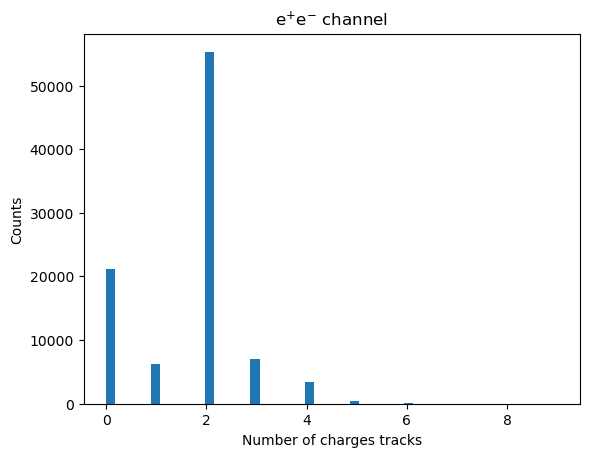

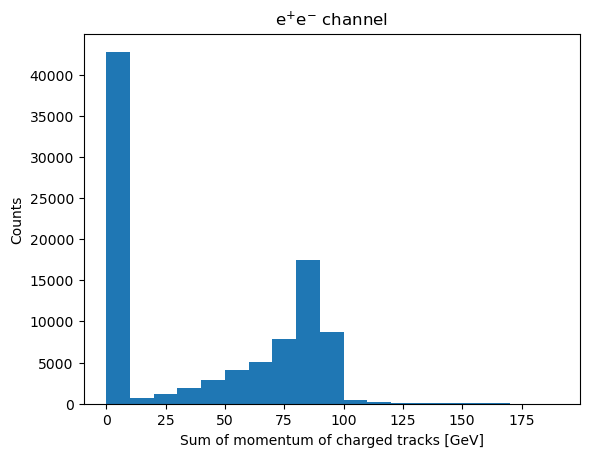

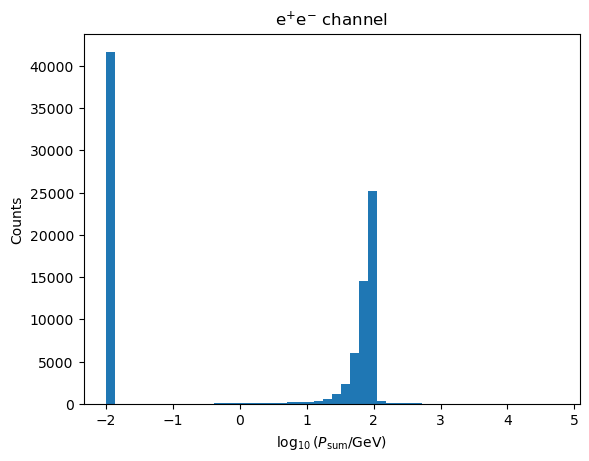

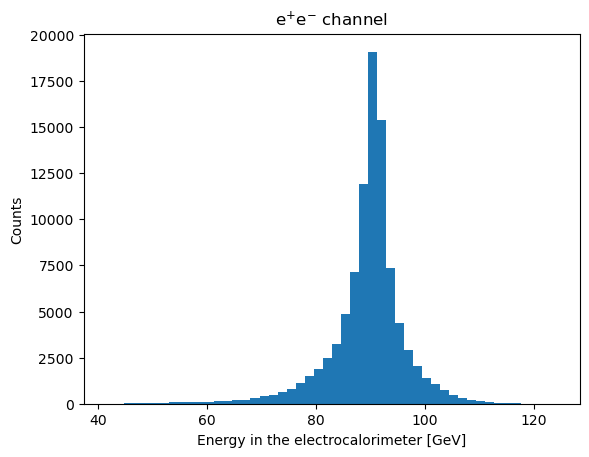

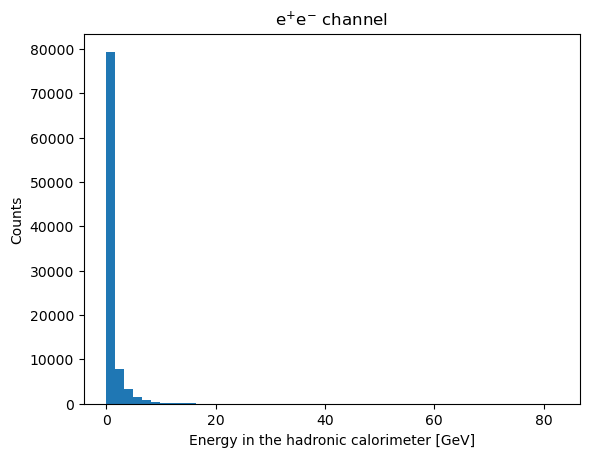

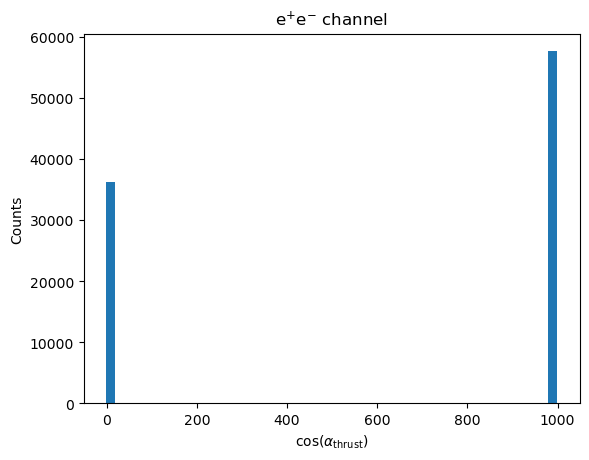

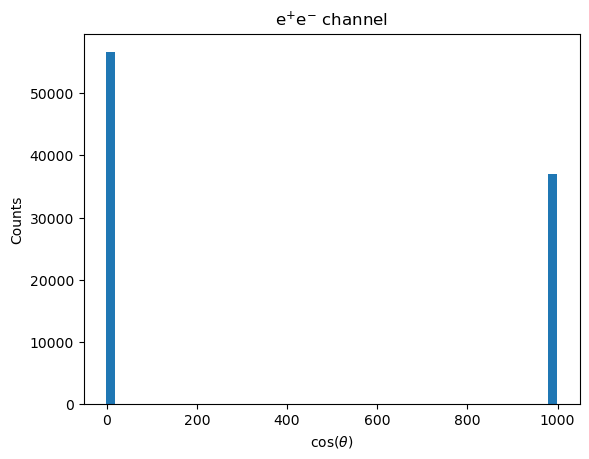

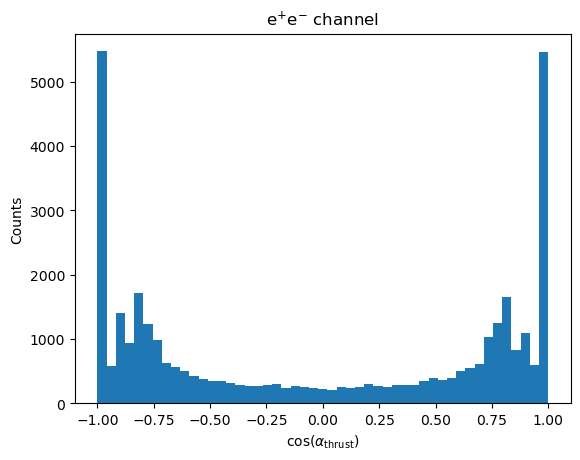

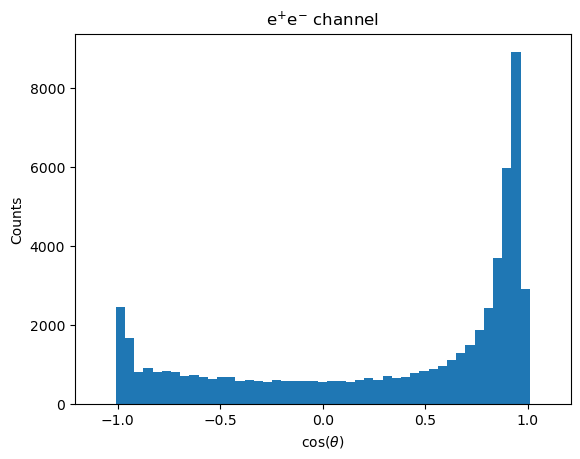

In [345]:
# Example for a single channel

file = uproot.open("../Data/MC/ee.root")
tree = file['h3']

Ncharged = np.array(tree['Ncharged'].array())
Pcharged = np.array(tree['Pcharged'].array())
E_ecal = np.array(tree['E_ecal'].array())
E_hcal = np.array(tree['E_hcal'].array())
cos_thru = np.array(tree['cos_thru'].array())
cos_thet = np.array(tree['cos_thet'].array())


plt.hist(Ncharged,bins=50)
plt.xlabel("Number of charges tracks")
plt.ylabel("Counts")
plt.title(r"$\rm{e^{+}e^{-}}$ channel")
plt.show()
# plt.savefig("../Figures/example.pdf") ## Use plt.savefig(<str filename>) to save the figures

plt.hist(Pcharged, bins=np.arange(0, 200, 10))
plt.xlabel("Sum of momentum of charged tracks [GeV]")
plt.ylabel("Counts")
plt.title(r"$\rm{e^{+}e^{-}}$ channel")
plt.show()

plt.hist(np.log10(Pcharged+0.01),bins=50)
plt.xlabel(r"$\log_{10} (P_{\rm{sum}} / \rm{GeV})$")
plt.ylabel("Counts")
plt.title(r"$\rm{e^{+}e^{-}}$ channel")
plt.show()

plt.hist(E_ecal,bins=50)
plt.xlabel("Energy in the electrocalorimeter [GeV]")
plt.ylabel("Counts")
plt.title(r"$\rm{e^{+}e^{-}}$ channel")
plt.show()

plt.hist(E_hcal,bins=50)
plt.xlabel("Energy in the hadronic calorimeter [GeV]")
plt.ylabel("Counts")
plt.title(r"$\rm{e^{+}e^{-}}$ channel")
plt.show()

plt.hist(cos_thru,bins=50)
plt.xlabel(r"$\cos(\alpha_{\rm{thrust}})$")
plt.ylabel("Counts")
plt.title(r"$\rm{e^{+}e^{-}}$ channel")
plt.show()

plt.hist(cos_thet,bins=50)
plt.xlabel(r"$\cos(\theta)$")
plt.ylabel("Counts")
plt.title(r"$\rm{e^{+}e^{-}}$ channel")
plt.show()

plt.hist(cos_thru,bins=np.linspace(-1,1,50))
plt.xlabel(r"$\cos(\alpha_{\rm{thrust}})$")
plt.ylabel("Counts")
plt.title(r"$\rm{e^{+}e^{-}}$ channel")
plt.show()

plt.hist(cos_thet,bins=np.linspace(-1.1,1.1,50))
plt.xlabel(r"$\cos(\theta)$")
plt.ylabel("Counts")
plt.title(r"$\rm{e^{+}e^{-}}$ channel")
plt.show()

### Questions

Three plots were "redefined".

1. For $P_{\rm{sum}}$, we used log10 (and had to add 0.01). Why?
   => P_Sum might be 0 because of momentum conservation (p_vec_1 + p_vec_2 might be 0 (opposite fly directions))
3. For the angles, we need to constrain to the physical values, i.e., $-1 < \cos(\theta) < 1$. What happened to the events with unphysical angles?
   => In some events, it is not possible to meassure (reconstruct) the angles => classify them as angle meassurement did not work which is done by setting cos(theta) ~ 1000. Those events are happening as well at the real detector => so keep those events for charcterisation of the detector. (for later cross-section analysis they are excluded)

### Exercises

2.1.0. Every plot in this protocol/example notebook has been plotted with the standard style options. Are these the best options in general? For each case? Do you think you can come up with better looking/easier to read plots?

2.1.1. Obtain the same histogram for the other three channels (the input root files are located in the same folder).

2.1.2. Come up with a nice way to show the comparison between the four channels

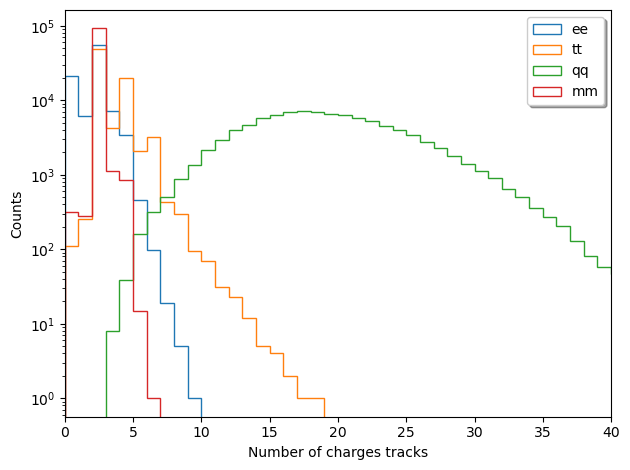

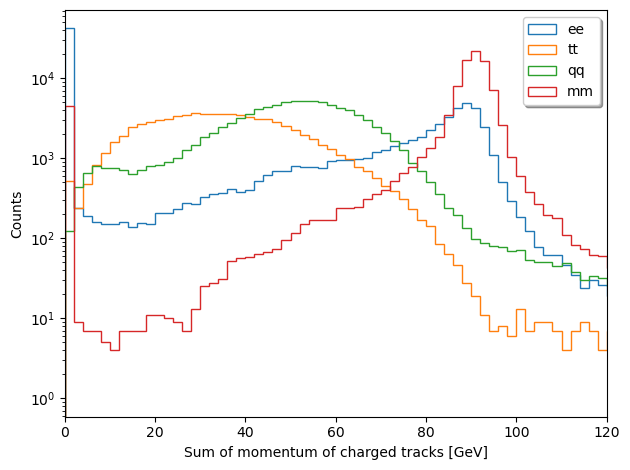

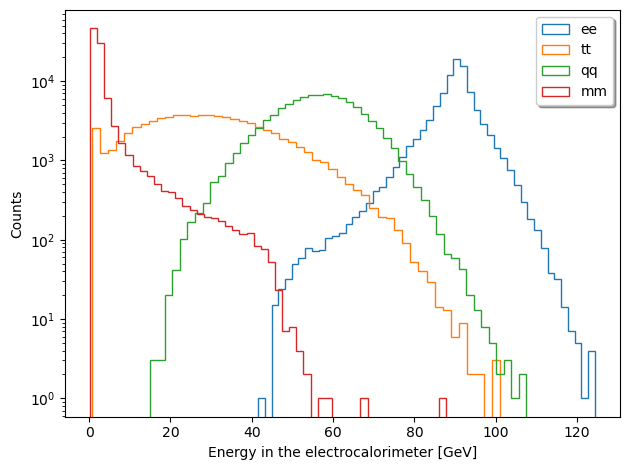

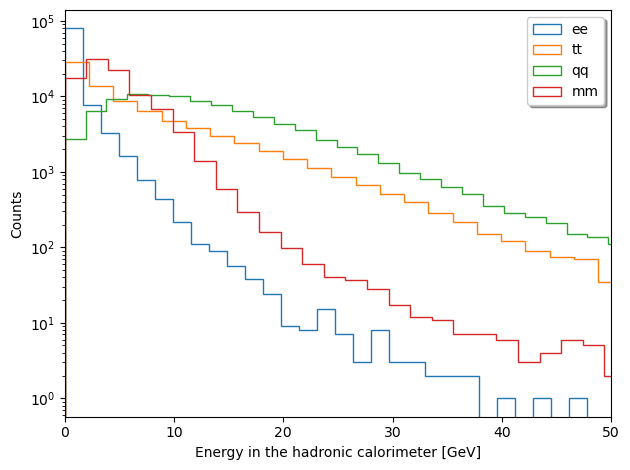

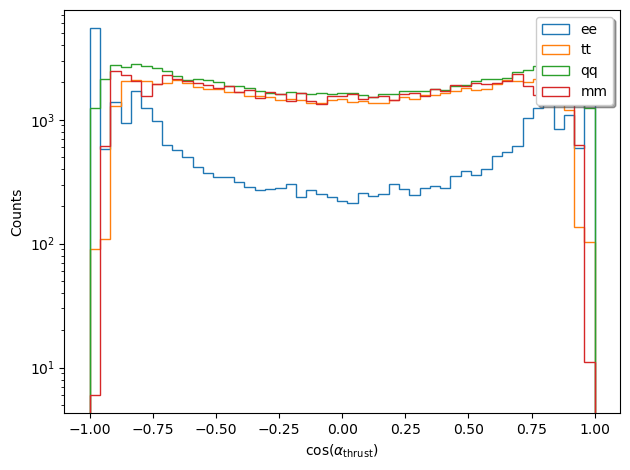

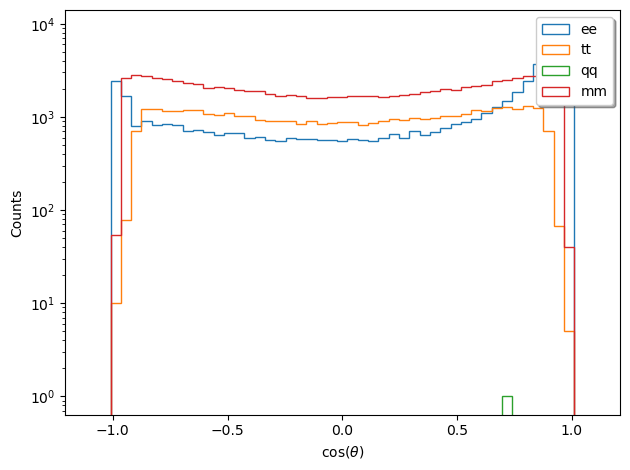

In [348]:
# Example for a single channel

fileNames = ["ee", "tt", "qq", "mm"]
files = [uproot.open(f"../Data/MC/{f}.root") for f in fileNames]
trees = [f['h3'] for f in files]


for i, t in enumerate(trees):
    plt.hist(t['Ncharged'].array(), bins = np.arange(0, 50, 1), histtype='step', label = fileNames[i])

plt.xlim(0, 40)
plt.xlabel("Number of charges tracks")
plt.ylabel("Counts")
plt.legend(shadow = True, fancybox = True, loc = "upper right")
plt.yscale("log")
plt.tight_layout()
plt.savefig("ch_distribution_num_tracks.pdf")
plt.show()


for i, t in enumerate(trees):
    plt.hist(t['Pcharged'].array(), bins = np.arange(0, 200, 2), histtype='step', label = fileNames[i])
plt.xlim(0, 120)
plt.xlabel("Sum of momentum of charged tracks [GeV]")
plt.ylabel("Counts")
plt.legend(shadow = True, fancybox = True, loc = "upper right")
plt.yscale("log")
plt.tight_layout()
plt.savefig("ch_distribution_sum_momentum.pdf")
plt.show()


for i, t in enumerate(trees):
    plt.hist(t['E_ecal'].array(), bins = 50, histtype='step', label = fileNames[i])
plt.xlabel("Energy in the electrocalorimeter [GeV]")
plt.ylabel("Counts")
plt.legend(shadow = True, fancybox = True, loc = "upper right")
plt.yscale("log")
plt.tight_layout()
plt.savefig("ch_distribution_ecal_E.pdf")
plt.show()

for i, t in enumerate(trees):
    plt.hist(t['E_hcal'].array(),bins=50, histtype='step', label = fileNames[i])
plt.xlim(0, 50)
plt.xlabel("Energy in the hadronic calorimeter [GeV]")
plt.ylabel("Counts")
plt.legend(shadow = True, fancybox = True, loc = "upper right")
plt.yscale("log")
plt.tight_layout()
plt.savefig("ch_distribution_hcal_E.pdf")
plt.show()

for i, t in enumerate(trees):
    plt.hist(t['cos_thru'].array(), bins = np.linspace(-1, 1, 50), histtype='step', label = fileNames[i])
plt.xlabel(r"$\cos(\alpha_{\rm{thrust}})$")
plt.ylabel("Counts")
plt.legend(shadow = True, fancybox = True, loc = "upper right")
plt.yscale("log")
plt.tight_layout()
plt.savefig("ch_distribution_cos_thru.pdf")
plt.show()

for i, t in enumerate(trees):
    plt.hist(t['cos_thet'].array(), bins = np.linspace(-1.1, 1.1, 50), histtype='step', label = fileNames[i])
plt.xlabel(r"$\cos(\theta)$")
plt.ylabel("Counts")
plt.legend(shadow = True, fancybox = True, loc = "upper right")
plt.yscale("log")
plt.tight_layout()
plt.savefig("ch_distribution_cos_theta.pdf")
plt.show()

## Part 2.2 - Separating s-t channels

For $\rm{e^{+}e^{-}}$ channel, not only annihiliation processes (s-channel) are present, but also scattering processes (t-channel). Nevertheless, the Z0 boson can only be produced in the first one and, thus, only those events contribute to the decay width. For that reason, those events must also be selected out.

The two channels differ on their angular distribution:

$\frac{d\sigma}{d\Omega} \alpha \left\{\begin{array}{@{}lr@{}}
        1+\cos^2(\theta), & \text{s-channel}\\
        (1-\cos \theta)^{-2}, & \text{t-channel}\\
        \end{array}\right.$

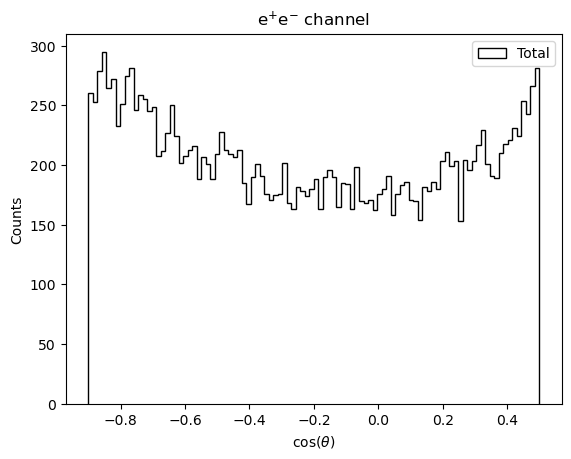

In [349]:
file = uproot.open("../Data/MC/ee.root")
tree = file['h3']

cos_thet = np.array(tree['cos_thet'].array())

# A first safe cos_theta cut must be applied

mask_safe = (cos_thet>-0.9) & (cos_thet<0.5)

data_hist = plt.hist(cos_thet[mask_safe],bins=np.linspace(-0.9,0.5,101),color='black',label='Total',histtype='step')
plt.xlabel(r"$\cos(\theta)$")
plt.ylabel("Counts")
plt.title(r"$\rm{e^{+}e^{-}}$ channel")
plt.legend()
plt.show()

We now define a fit function of the type:

$a (1+\cos^2(\theta)) + b (1-\cos \theta)^{-2}$

where $a$ and $b$ are free parameters

In [350]:
def fitFunction(x,a,b):
    return(a*(1+x*x) + b*1/(1-x)**2)

def fitFunctionSig(x, siga, sigb):
    return np.sqrt( (siga * (1 + x * x))**2 + (sigb * 1 / (1-x)**2)**2 )

Fitted parameters:
a = 156.0605806321217 +- 1.745865192485392
b = 16.390767821098247 +- 1.5615445898817786


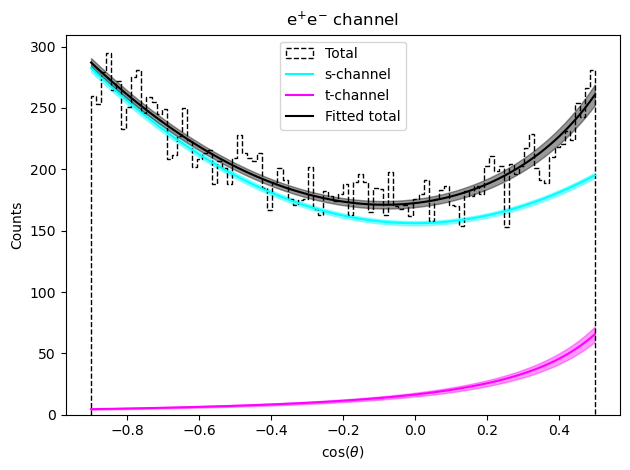

In [352]:
popt, pcov = curve_fit(fitFunction, data_hist[1][:-1] + (data_hist[1][1] - data_hist[1][0])/2., data_hist[0], bounds=(0,10000))
psig = np.sqrt(np.diag(pcov))

print("Fitted parameters:")
print(f"a = {popt[0]} +- { psig[0] }")
print(f"b = {popt[1]} +- { psig[1] }")

plt.hist(cos_thet[mask_safe],bins=np.linspace(-0.9,0.5,101),color='black',label='Total',histtype='step',linestyle='--')

plt.plot(np.linspace(-0.9,0.5,101),popt[0] * (1+np.linspace(-0.9,0.5,101) ** 2),label='s-channel',color='cyan')
plt.fill_between(np.linspace(-0.9,0.5,101),(popt[0]-np.sqrt(np.diag(pcov))[0]) * (1+np.linspace(-0.9,0.5,101) ** 2),(popt[0]+np.sqrt(np.diag(pcov))[0]) * (1+np.linspace(-0.9,0.5,101) ** 2),alpha=0.4,color='cyan')

plt.plot(np.linspace(-0.9,0.5,101),popt[1] * 1/(1-np.linspace(-0.9,0.5,101)) ** 2,label='t-channel',color='magenta')
plt.fill_between(np.linspace(-0.9,0.5,101),(popt[1]-np.sqrt(np.diag(pcov))[1]) * 1/(1-np.linspace(-0.9,0.5,101)) ** 2,(popt[1]+np.sqrt(np.diag(pcov))[1]) * 1/(1-np.linspace(-0.9,0.5,101)) ** 2,alpha=0.4,color='magenta')

plt.plot(np.linspace(-0.9,0.5,101),popt[0] * (1+np.linspace(-0.9,0.5,101) ** 2) + popt[1] * 1/(1-np.linspace(-0.9,0.5,101)) ** 2,color='black',label='Fitted total')
plt.fill_between(np.linspace(-0.9,0.5,101),(popt[0]-np.sqrt(np.diag(pcov))[0]) * (1+np.linspace(-0.9,0.5,101) ** 2) + (popt[1]-np.sqrt(np.diag(pcov))[1]) * 1/(1-np.linspace(-0.9,0.5,101)) ** 2,(popt[0]+np.sqrt(np.diag(pcov))[0]) * (1+np.linspace(-0.9,0.5,101) ** 2) + (popt[1]+np.sqrt(np.diag(pcov))[1]) * 1/(1-np.linspace(-0.9,0.5,101)) ** 2,alpha=0.4,color='black')

plt.xlabel(r"$\cos(\theta)$")
plt.ylabel("Counts")
plt.title(r"$\rm{e^{+}e^{-}}$ channel")
plt.legend()
plt.tight_layout()
plt.savefig("st_channel.pdf")
plt.show()

### Exercises

Using the results of the fit:

2.2.1. Calculate the fraction of s-channel events in the region $\cos \theta \in [-0.9,0.5]$

2.2.2. Calculate the total number of s-channel events in $\cos \theta \in [-1,1]$

In [353]:
integrationStepWidth = 0.01

# integration -0.9 to 0.5
integrationPoints = np.arange(-0.9, 0.5 + integrationStepWidth / 2, integrationStepWidth)

totalEventCount = sum(fitFunction(integrationPoints, popt[0], popt[1]) * integrationStepWidth)
totalEventCountSig = np.sqrt(sum(fitFunctionSig(integrationPoints, psig[0], 0) * integrationStepWidth)**2 + sum(fitFunctionSig(integrationPoints, 0, psig[1]) * integrationStepWidth)**2)

sChannelEventCount = sum(fitFunction(integrationPoints, popt[0], 0) * integrationStepWidth)
sChannelEventCountSig = sum(fitFunctionSig(integrationPoints, psig[0], 0) * integrationStepWidth)


fracSChannel = sChannelEventCount / totalEventCount
fracSChannelSig = np.sqrt( (sChannelEventCountSig / totalEventCount)**2 + (sChannelEventCount / totalEventCount**2 * totalEventCountSig)**2)

print("For cos theta in [-0.9, 0.5]:")
print(f"  Frac: {fracSChannel * 100:.2f} +- {fracSChannelSig * 100:.2f}%, total s count: {sChannelEventCount:.1f} +- {sChannelEventCountSig:.1f}")

# integration -1 to 0.95
integrationPoints = np.arange(-1, 0.95 + integrationStepWidth / 2, integrationStepWidth)

sChannelEventCount = sum(fitFunction(integrationPoints, popt[0], 0) * integrationStepWidth)
sChannelEventCountSig = sum(fitFunctionSig(integrationPoints, psig[0], 0) * integrationStepWidth)

print("For cos theta in [-1, 0.95]:")
print(f"  Total s count: {sChannelEventCount:.1f} +- {sChannelEventCountSig:.1f}")

For cos theta in [-0.9, 0.5]:
  Frac: 91.54 +- 1.57%, total s count: 265.3 +- 3.0
For cos theta in [-1, 0.95]:
  Total s count: 404.0 +- 4.5


In [354]:
integrationPoints = np.arange(-0.9, 0.5 + integrationStepWidth / 2, integrationStepWidth)
sCut = sum(fitFunction(integrationPoints, popt[0], 0) / fitFunction(integrationPoints, popt[0], popt[1]) * integrationStepWidth)

integrationPoints = np.arange(-1, 0.99 + integrationStepWidth / 2, integrationStepWidth)
sTotal = sum(fitFunction(integrationPoints, popt[0], 0) / fitFunction(integrationPoints, popt[0], popt[1]) * integrationStepWidth)

stScalingFactor = sTotal / sCut

print(f"Scaling factor {stScalingFactor:.2f}")

Scaling factor 1.24


## Part 2.3 - Defining selection cuts

As we just learned, events cannot be singularly defined, but they can be defined by their distributions. The idea of this part if to come up with four sets of cuts to separate the four channels

In [355]:
def getMaskForEE(additionalMask, ecalE, hcalE, sumP, ctrkN):
    return additionalMask & ~(hcalE > 0.6) & (ecalE > 85)

def getMaskForMM(additionalMask, ecalE, hcalE, sumP, ctrkN):
    return additionalMask & ~((ecalE > 30) | (sumP < 70) | (ctrkN > 2))

def getMaskForTT(additionalMask, ecalE, hcalE, sumP, ctrkN):
    return additionalMask & ~((sumP > 80) | (ecalE > 80) | (sumP > 80) | (ecalE + hcalE < 20) | (ctrkN > 10) | (ecalE + hcalE > 70))

def getMaskForQQ(additionalMask, ecalE, hcalE, sumP, ctrkN):
    return additionalMask & ~(ctrkN < 10)

masksLabels = ["mask for ee", "mask for mm", "mask for tt", "mask for qq"]
masks = [getMaskForEE, getMaskForMM, getMaskForTT, getMaskForQQ]

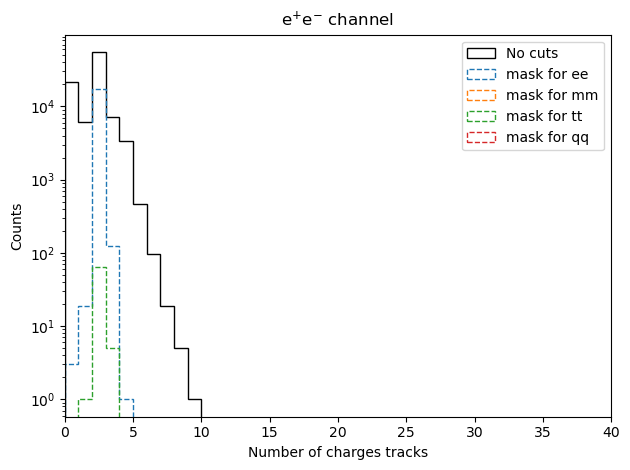

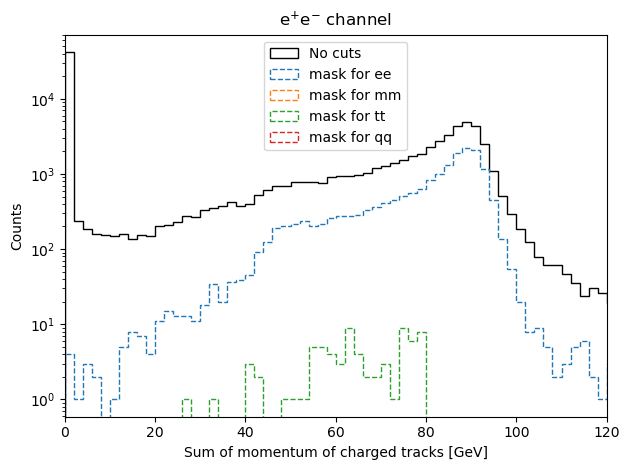

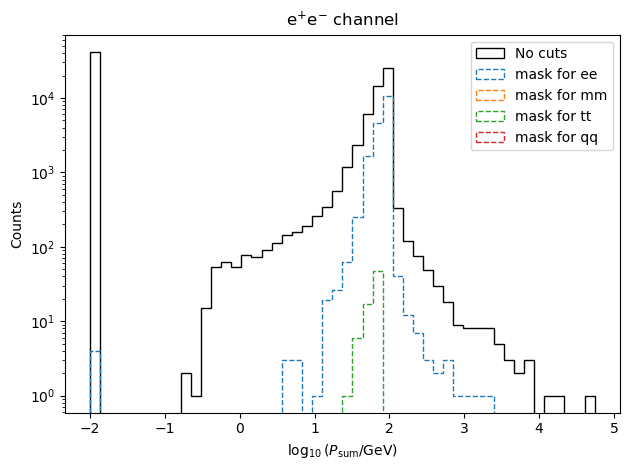

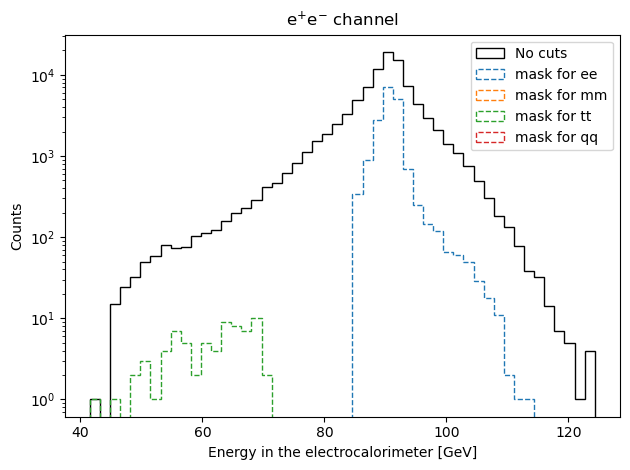

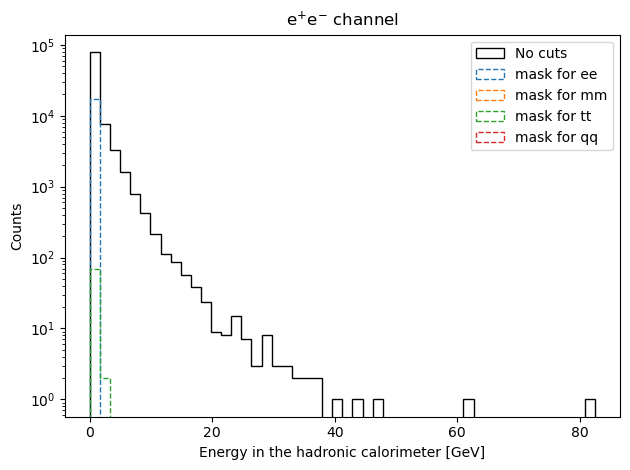

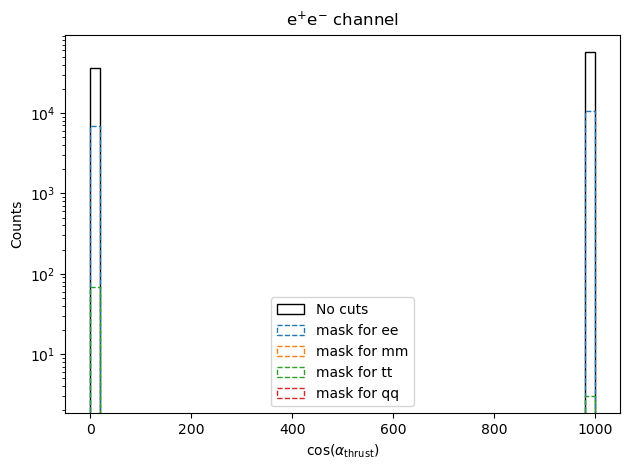

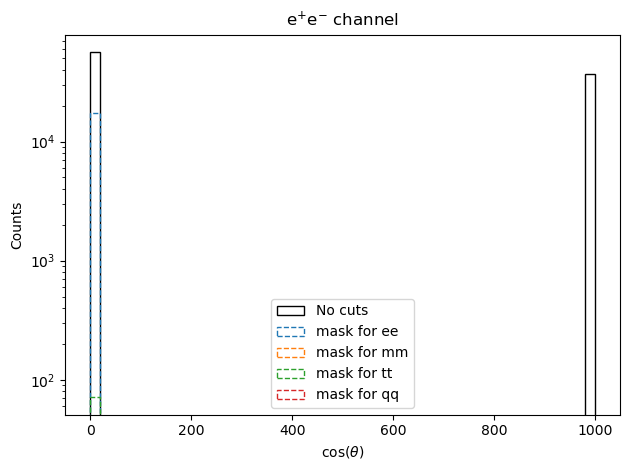

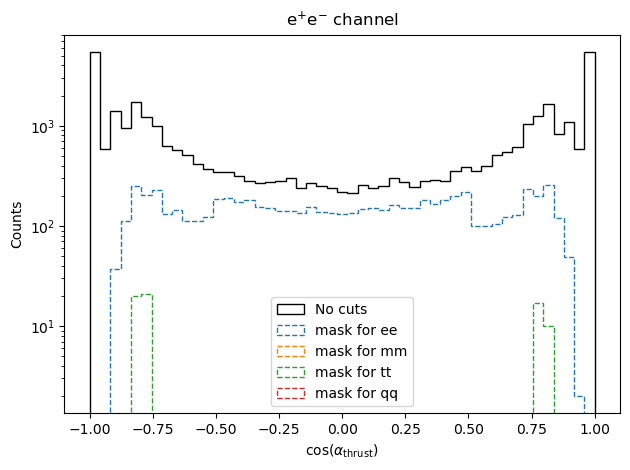

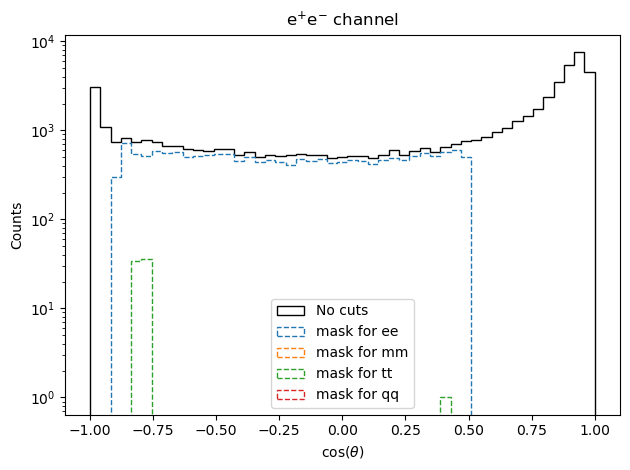

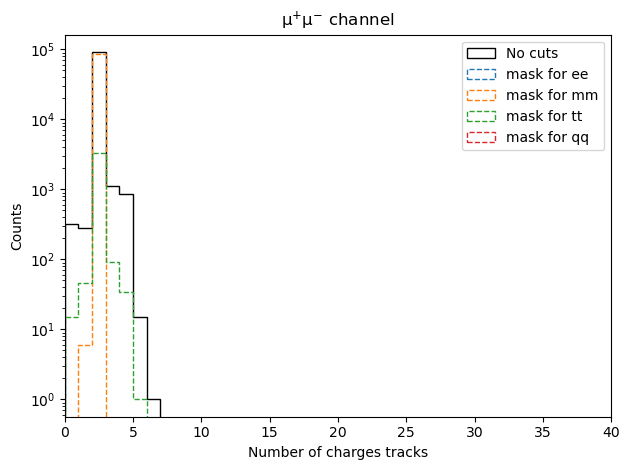

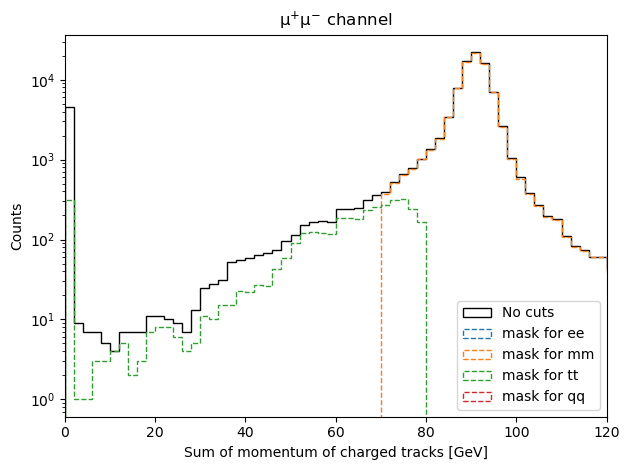

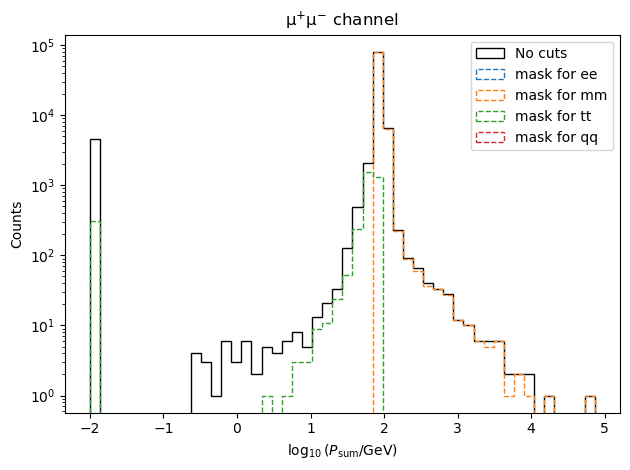

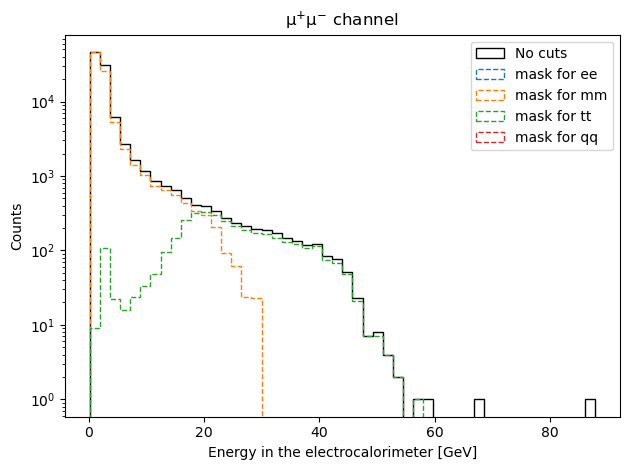

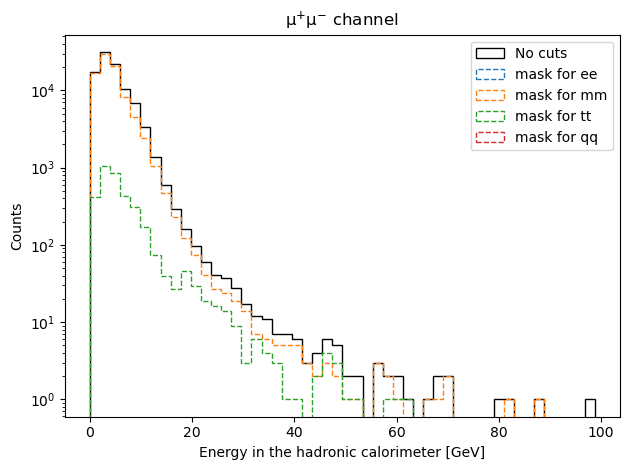

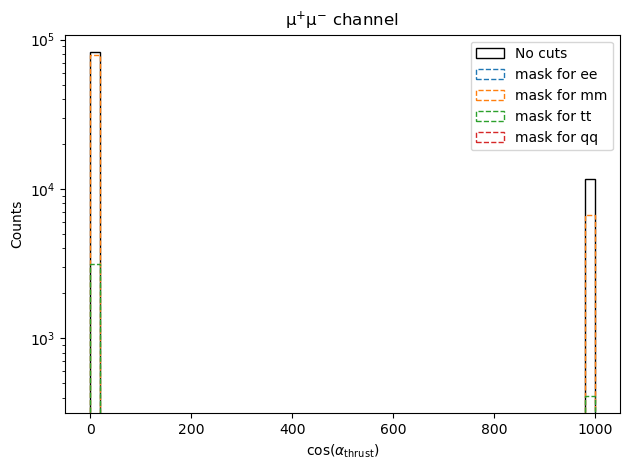

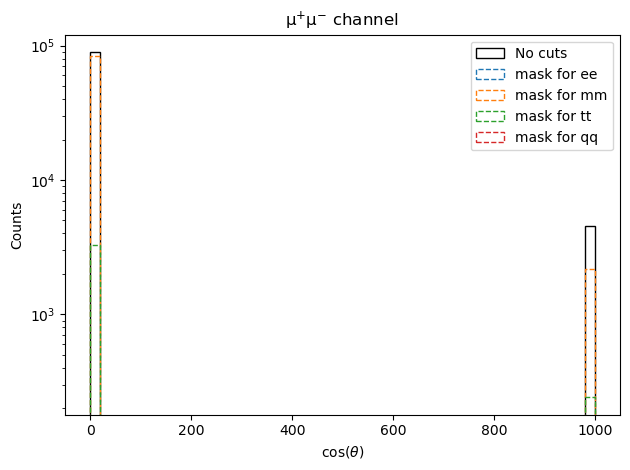

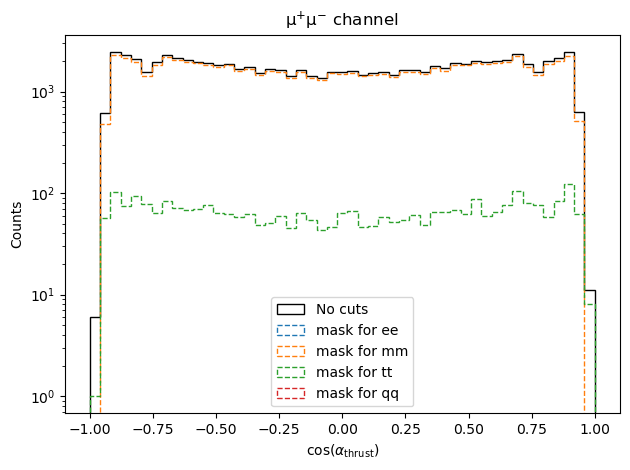

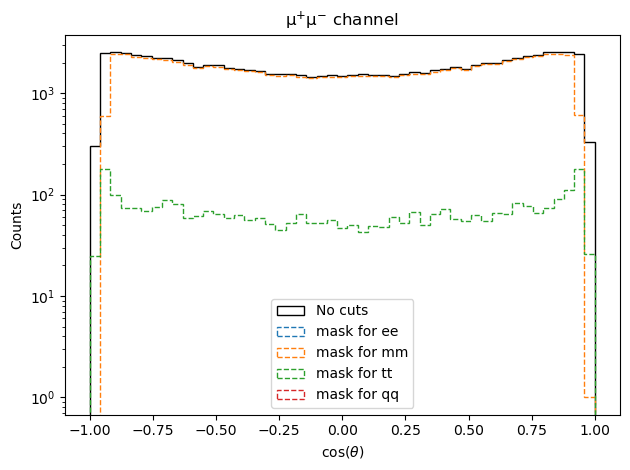

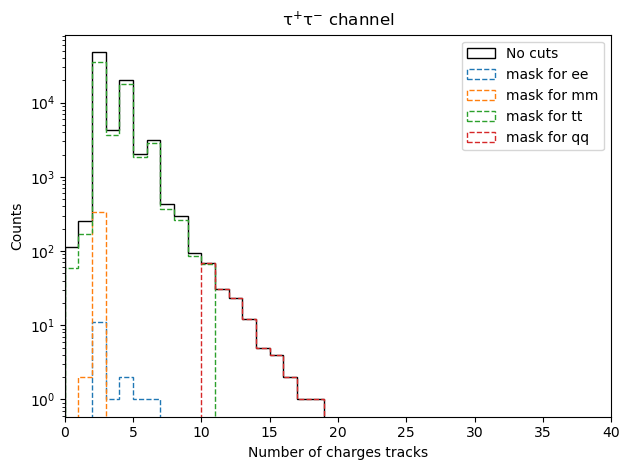

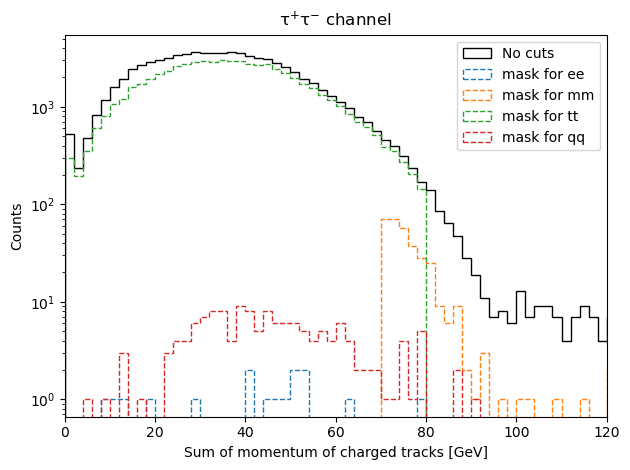

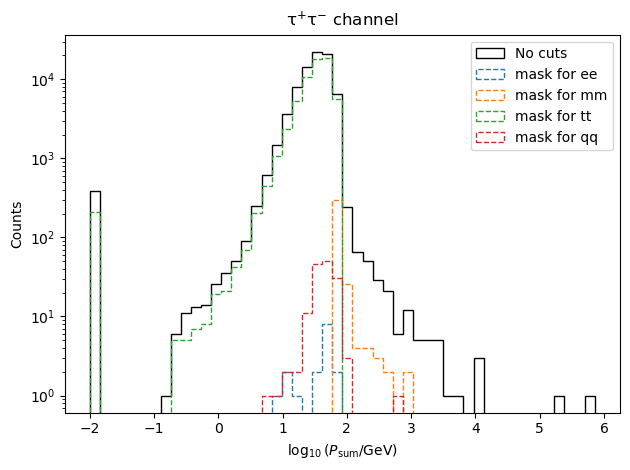

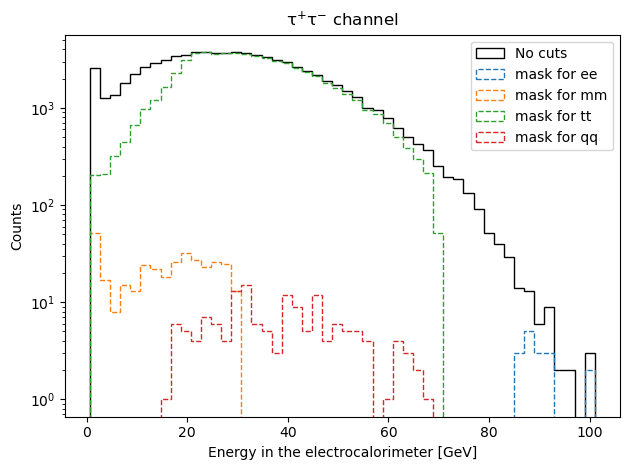

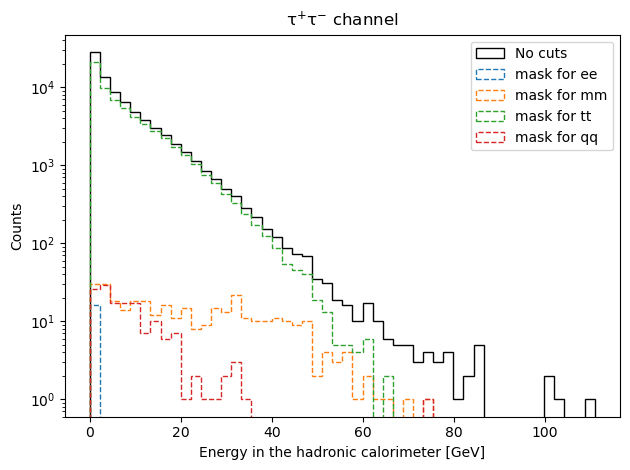

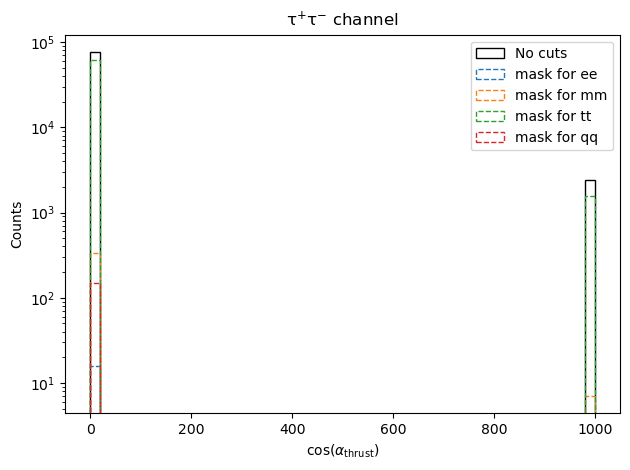

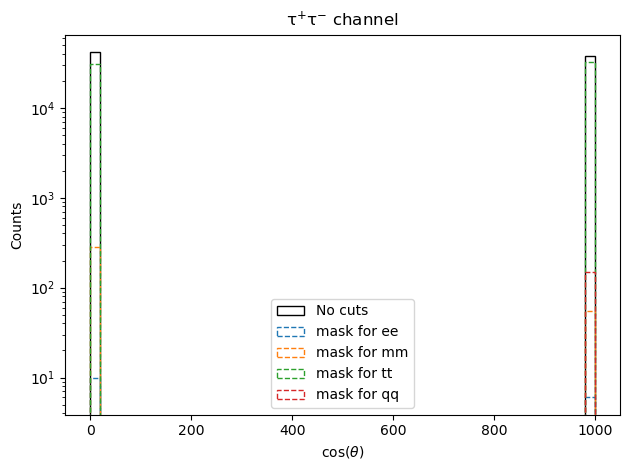

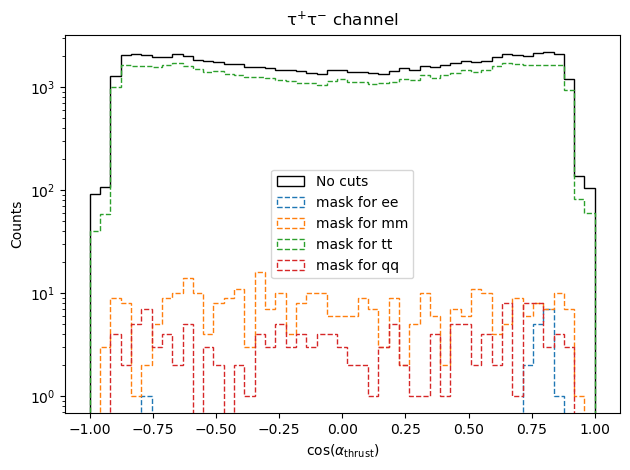

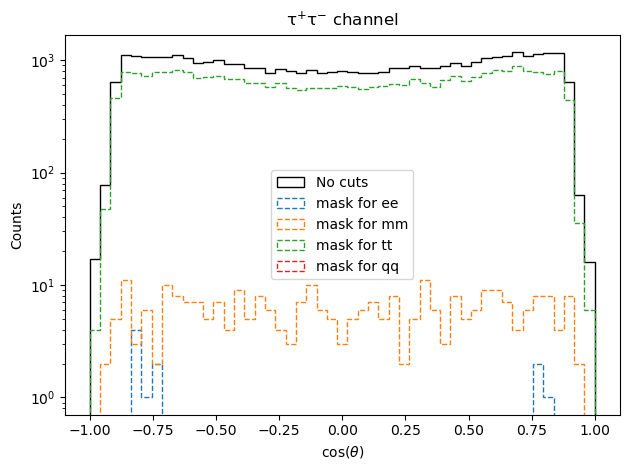

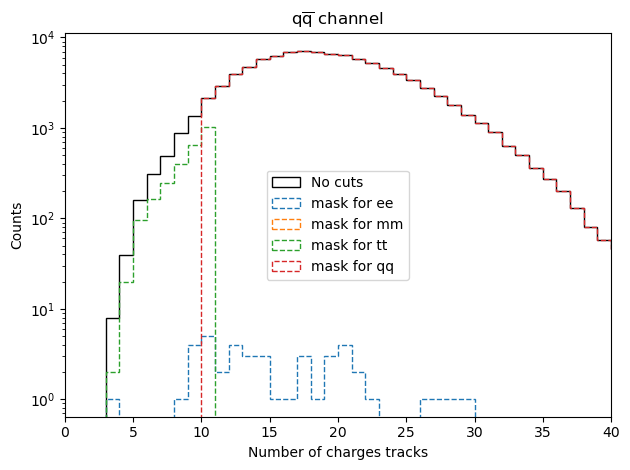

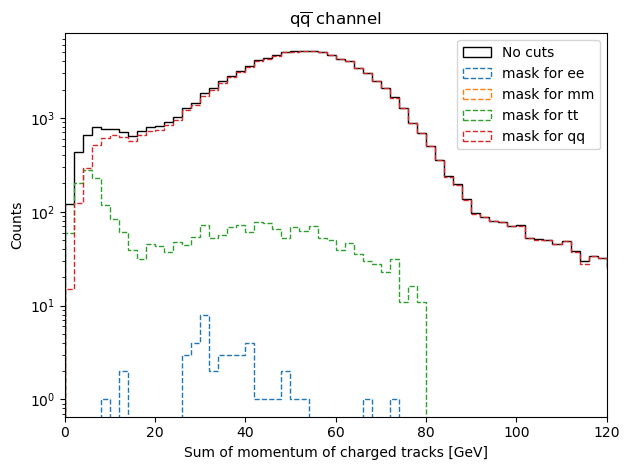

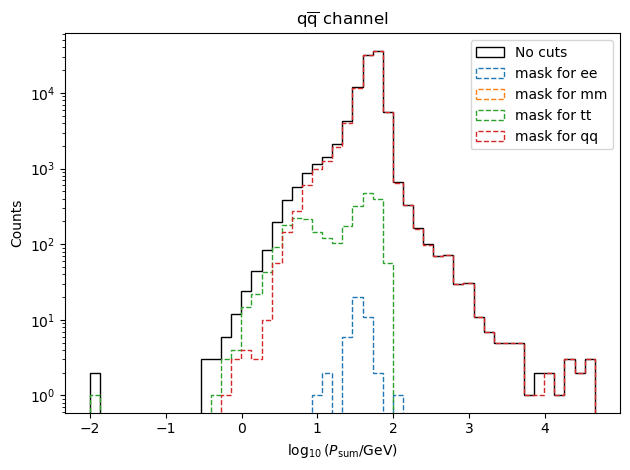

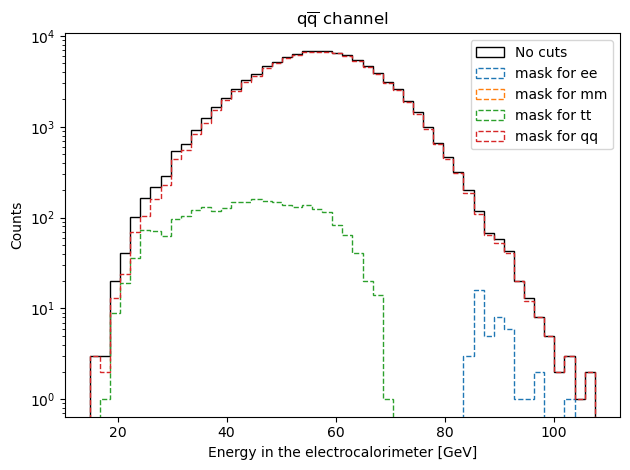

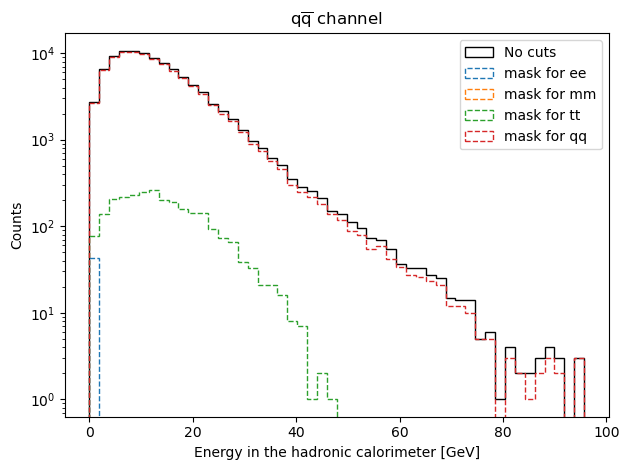

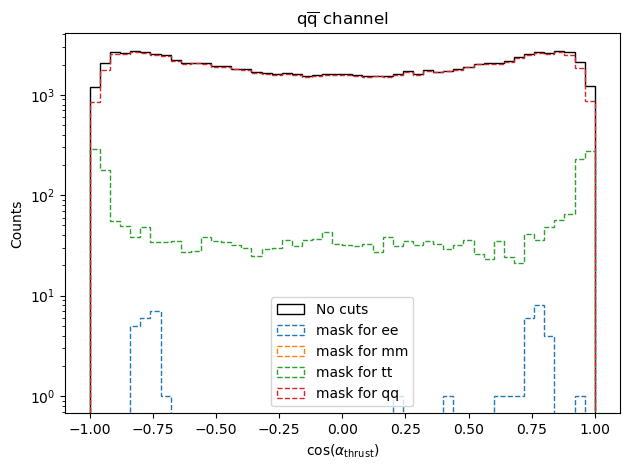

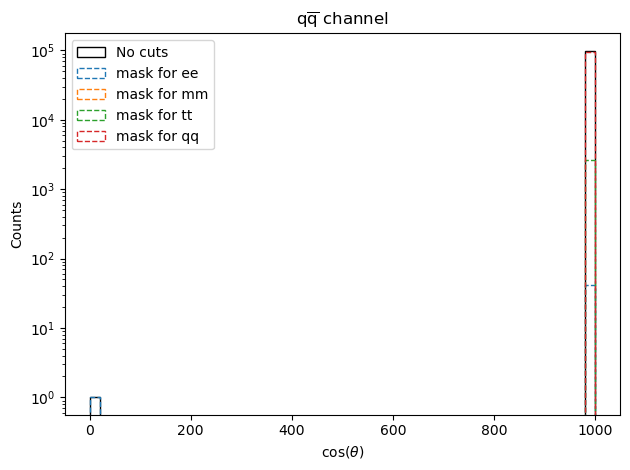

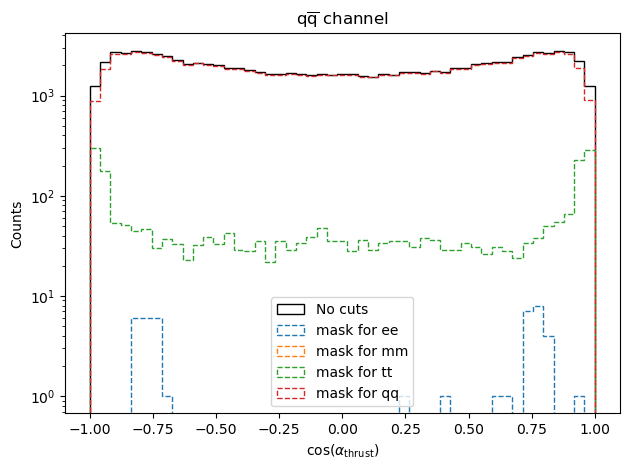

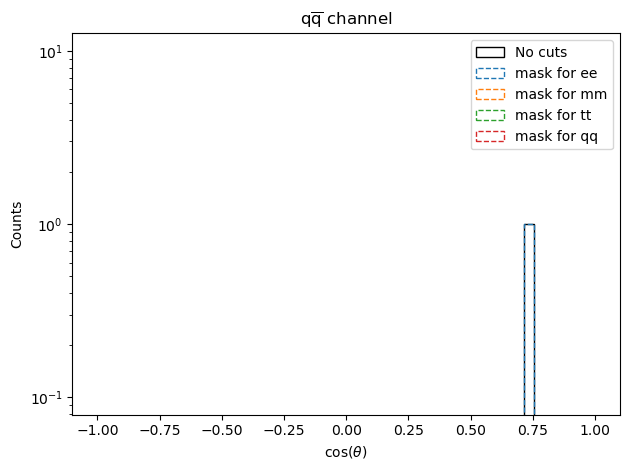

In [357]:
# Example for a single channel

titles = {"ee" : r"$\rm{e^{+}e^{-}}$ channel", "mm" : r"$\rm{\mu^{+}\mu^{-}}$ channel", "tt" : r"$\rm{\tau^{+}\tau^{-}}$ channel", "qq" : r"$\rm{q} \overline{\rm{q}}$ channel"}

for fileName in ["ee", "mm", "tt", "qq"]:
    file = uproot.open(f"../Data/MC/{fileName}.root")
    tree = file['h3']
    
    Ncharged = np.array(tree['Ncharged'].array())
    Pcharged = np.array(tree['Pcharged'].array())
    E_ecal = np.array(tree['E_ecal'].array())
    E_hcal = np.array(tree['E_hcal'].array())
    cos_thru = np.array(tree['cos_thru'].array())
    cos_thet = np.array(tree['cos_thet'].array())
    
    mask_safe = (cos_thet > -0.9) & (cos_thet < 0.5) # If looking for ee, this cut must be kept due to the s-t contamination! For other channels this can (and maybe should) be taken out
    if fileName == "ee":
        additionalMask =  mask_safe
    else:
        additionalMask = np.ones(np.shape(mask_safe), dtype = bool)
    
    
    _, bins, _ = plt.hist(Ncharged, bins = np.arange(0, 50, 1),color='black',label='No cuts',histtype='step')
    for i in range(4):
        plt.hist(Ncharged[masks[i](additionalMask, E_ecal, E_hcal, Pcharged, Ncharged)], bins=bins, linestyle = '--', histtype = 'step', label = masksLabels[i])
    
    plt.xlim(0, 40)
    plt.xlabel("Number of charges tracks")
    plt.ylabel("Counts")
    plt.title(titles[fileName])
    plt.legend()
    plt.yscale("log")
    plt.tight_layout()
    plt.savefig(f"{fileName} charged_number_tracks.pdf")
    plt.show()
    
    
    _, bins, _ = plt.hist(Pcharged, bins = np.arange(0, 200, 2),color='black',label='No cuts',histtype='step')
    for i in range(4):
        plt.hist(Pcharged[masks[i](additionalMask, E_ecal, E_hcal, Pcharged, Ncharged)], bins=bins, linestyle = '--', histtype = 'step', label = masksLabels[i])
    
    plt.xlim(0, 120)
    plt.xlabel("Sum of momentum of charged tracks [GeV]")
    plt.ylabel("Counts")
    plt.title(titles[fileName])
    plt.legend()
    plt.yscale("log")
    plt.tight_layout()
    plt.savefig(f"{fileName} sum_momentum.pdf")
    plt.show()
    
    _, bins, _ = plt.hist(np.log10(Pcharged+0.01),bins=50,color='black',label='No cuts',histtype='step')
    for i in range(4):
        plt.hist(np.log10(Pcharged+0.01)[masks[i](additionalMask, E_ecal, E_hcal, Pcharged, Ncharged)], bins=bins, linestyle = '--', histtype = 'step', label = masksLabels[i])
    
    plt.xlabel(r"$\log_{10} (P_{\rm{sum}} / \rm{GeV})$")
    plt.ylabel("Counts")
    plt.title(titles[fileName])
    plt.legend()
    plt.yscale("log")
    plt.tight_layout()
    plt.savefig(f"{fileName} sum_momentum_log.pdf")
    plt.show()
    
    _, bins, _ = plt.hist(E_ecal,bins=50,color='black',label='No cuts',histtype='step')
    for i in range(4):
        plt.hist(E_ecal[masks[i](additionalMask, E_ecal, E_hcal, Pcharged, Ncharged)], bins=bins, linestyle = '--', histtype = 'step', label = masksLabels[i])
        
    plt.xlabel("Energy in the electrocalorimeter [GeV]")
    plt.ylabel("Counts")
    plt.title(titles[fileName])
    plt.legend()
    plt.yscale("log")
    plt.tight_layout()
    plt.savefig(f"{fileName} ecal_E.pdf")
    plt.show()
    
    _, bins, _ = plt.hist(E_hcal,bins=50,color='black',label='No cuts',histtype='step')
    for i in range(4):
        plt.hist(E_hcal[masks[i](additionalMask, E_ecal, E_hcal, Pcharged, Ncharged)], bins=bins, linestyle = '--', histtype = 'step', label = masksLabels[i])
    
    plt.xlabel("Energy in the hadronic calorimeter [GeV]")
    plt.ylabel("Counts")
    plt.title(titles[fileName])
    plt.legend()
    plt.yscale("log")
    plt.tight_layout()
    plt.savefig(f"{fileName} hcal_E.pdf")
    plt.show()
    
    _, bins, _ = plt.hist(cos_thru,bins=50,color='black',label='No cuts',histtype='step')
    for i in range(4):
        plt.hist(cos_thru[masks[i](additionalMask, E_ecal, E_hcal, Pcharged, Ncharged)], bins=bins, linestyle = '--', histtype = 'step', label = masksLabels[i])
    
    plt.xlabel(r"$\cos(\alpha_{\rm{thrust}})$")
    plt.ylabel("Counts")
    plt.title(titles[fileName])
    plt.legend()
    plt.yscale("log")
    plt.tight_layout()
    plt.savefig(f"{fileName} cos alpha compl range.pdf")
    plt.show()
    
    
    _, bins, _ = plt.hist(cos_thet,bins=50,color='black',label='No cuts',histtype='step')
    for i in range(4):
        plt.hist(cos_thet[masks[i](additionalMask, E_ecal, E_hcal, Pcharged, Ncharged)], bins=bins, linestyle = '--', histtype = 'step', label = masksLabels[i])
    
    plt.xlabel(r"$\cos(\theta)$")
    plt.ylabel("Counts")
    plt.title(titles[fileName])
    plt.legend()
    plt.yscale("log")
    plt.tight_layout()
    plt.savefig(f"{fileName} cos theta compl range.pdf")
    plt.show()
    
    
    _, bins, _ = plt.hist(cos_thru,bins=np.linspace(-1,1,50),color='black',label='No cuts',histtype='step')
    for i in range(4):
        plt.hist(cos_thru[masks[i](additionalMask, E_ecal, E_hcal, Pcharged, Ncharged)], bins=bins, linestyle = '--', histtype = 'step', label = masksLabels[i])
        
    plt.xlabel(r"$\cos(\alpha_{\rm{thrust}})$")
    plt.ylabel("Counts")
    plt.title(titles[fileName])
    plt.legend()
    plt.yscale("log")
    plt.tight_layout()
    plt.savefig(f"{fileName} cos alpha limited range.pdf")
    plt.show()
    
    _, bins, _ = plt.hist(cos_thet,bins=np.linspace(-1,1,50),color='black',label='No cuts',histtype='step')
    for i in range(4):
        plt.hist(cos_thet[masks[i](additionalMask, E_ecal, E_hcal, Pcharged, Ncharged)], bins=bins, linestyle = '--', histtype = 'step', label = masksLabels[i])
        
    plt.xlabel(r"$\cos(\theta)$")
    plt.ylabel("Counts")
    plt.title(titles[fileName])
    plt.legend()
    plt.yscale("log")
    plt.tight_layout()
    plt.savefig(f"{fileName} cos theta limited range.pdf")
    plt.show()

## 2.3.2

In [358]:
fractionsCorr = np.zeros((4, 4))
fractionsNotCorr = np.zeros((4, 4))
eventCounts = np.zeros(4)

fileNames = ["ee", "mm", "tt", "qq"]
for useThetaMask in [False, True]:
    print()
    print("Use Theta Mask?", useThetaMask)
    print()

    if useThetaMask:
        targetFracArr = fractionsCorr
    else:
        targetFracArr = fractionsNotCorr
    
    for i, fileName in enumerate(fileNames):
        file = uproot.open(f"../Data/MC/{fileName}.root")
        tree = file['h3']
        
        Ncharged = np.array(tree['Ncharged'].array())
        Pcharged = np.array(tree['Pcharged'].array())
        E_ecal = np.array(tree['E_ecal'].array())
        E_hcal = np.array(tree['E_hcal'].array())
        cos_thru = np.array(tree['cos_thru'].array())
        cos_thet = np.array(tree['cos_thet'].array())

        eventCounts[i] = len(cos_thet)
        
        cosThetaMask = (cos_thet > -0.9) & (cos_thet < 0.5) # If looking for ee, this cut must be kept due to the s-t contamination! For other channels this can (and maybe should) be taken out
        if fileName == "ee" and useThetaMask:
            additionalMask = cosThetaMask
        else:
            additionalMask = np.ones(np.shape(cosThetaMask), dtype = bool)
        

        if i == 0:
            eS = sum(cosThetaMask)
        
        print(fileName, "-dataset:")
        totalEventsI = 100000
        for j in range(4):
            currMask = masks[j](additionalMask, E_ecal, E_hcal, Pcharged, Ncharged)
            
            if j == 0:
                print(eS)
                targetFracArr[i, j] = sum(currMask) / (eS * stScalingFactor)
            else:
                targetFracArr[i, j] = sum(currMask) / totalEventsI
            
            print(f"{fileNames[j]} : {targetFracArr[i, j] * 100:.2f}%  ", end = "")
        print()
        print()


Use Theta Mask? False

ee -dataset:
20531
ee : 220.42%  mm : 0.00%  tt : 1.24%  qq : 0.00%  

mm -dataset:
20531
ee : 0.00%  mm : 85.23%  tt : 3.54%  qq : 0.00%  

tt -dataset:
20531
ee : 0.06%  mm : 0.34%  tt : 62.70%  qq : 0.15%  

qq -dataset:
20531
ee : 0.17%  mm : 0.00%  tt : 2.60%  qq : 95.31%  


Use Theta Mask? True

ee -dataset:
20531
ee : 68.60%  mm : 0.00%  tt : 0.07%  qq : 0.00%  

mm -dataset:
20531
ee : 0.00%  mm : 85.23%  tt : 3.54%  qq : 0.00%  

tt -dataset:
20531
ee : 0.06%  mm : 0.34%  tt : 62.70%  qq : 0.15%  

qq -dataset:
20531
ee : 0.17%  mm : 0.00%  tt : 2.60%  qq : 95.31%  



infinite time and statistics -> no perfect matrix possible based in systemic errors: the detector isnt capable of cutting fine enough 
intinite percise detector -> no perfect matrix because of statistical errors (fluctuations) side effect: cutting out many right events

### Exercises

2.3.1. Come up with four sets of cuts, one for each channel and show the impact on the histograms for every channel for each cut.

2.3.2. Build a 4x4 matrix containing the fraction of events of MC simulations of channel $i$ surviving the cuts to select events of channel $j$.

2.3.3. Correct all the entries in the matrix for MC simulations of channel e+e- in order to keep only s-channel events using the numbers fracSChannel and totalSChannel calculated in the previous step.

### Questions

1. There are two numbers to calculate the fraction of surviving events. Either dividing by the number of events without cuts or diving by 100000 which is the initial number of MC simulations. Why are those numbers different? Which one should be used?
   Sometimes detector cannot measure event due to too high thresholds => event number decreases; use 100000
3. In an ideal world how do we expect this 4x4 matrix to look like?
   identity
4. How can measure which of two possible 4x4 matrices is better?
   calculate difference: 1 - matrix

In [359]:
acceptanceMatrix = np.copy(fractionsNotCorr).T # between 0-1
correctedAcceptanceMatrix = np.copy(fractionsCorr).T # corrected after s-t separation
totalNumberOfEvents = (eventCounts[np.newaxis, :] * fractionsCorr).T # real number of events used in the calculation

In [360]:
correctedAcceptanceMatrix 

array([[6.85958456e-01, 0.00000000e+00, 6.28886964e-04, 1.69013371e-03],
       [0.00000000e+00, 8.52320000e-01, 3.40000000e-03, 0.00000000e+00],
       [7.10000000e-04, 3.54300000e-02, 6.27020000e-01, 2.59500000e-02],
       [0.00000000e+00, 0.00000000e+00, 1.48000000e-03, 9.53070000e-01]])

# Part 3 - Getting the physical results

Now that we spent time learning from MC simulations how each channel works and quantitatively estimated the response of our analysis. We can apply it to real data, in which we cannot know what is the real channel that created that event.

With that we can estimate what was the initial total number of events in each channel and, thus, calculate the cross section and decay width.

## Part 3.1 - Calculate the number of real data events after cuts

From data, we have the total number of detected events for each energy bin, $k$, $N^{k}_{\rm{det}}$. We then apply each of our 4 cuts for each channel $j$, getting the number of detected events in each energy bin, $k$ and for each cut, $j$: $N^{j,k}_{\rm{det}}$

In [361]:
# Table with energy bins, don't change this

energy_bins = np.array([44, 44.5, 45, 45.4, 45.8, 46.2, 46.7, 47.2])

In [362]:
# Example for reading data and applying cuts

# Choose a dataset from 1, 2, 4, 5 or 6 (3 was faulty and therefore deleted)

datasets = [1, 2, 4, 5, 6]
dataset = datasets[0]

file = uproot.open(f"../Data/Real/daten_{dataset}.root")
tree = file['h33']

Ncharged = np.array(tree['Ncharged'].array())
Pcharged = np.array(tree['Pcharged'].array())
E_ecal = np.array(tree['E_ecal'].array())
E_hcal = np.array(tree['E_hcal'].array())
cos_thru = np.array(tree['cos_thru'].array())
E_lep = np.array(tree['E_lep'].array())
cos_thet = np.array(tree['cos_thet'].array())

mask_safe = (cos_thet > -0.9) & (cos_thet < 0.5) # If looking for ee, this cut must be kept due to the s-t contamination! For other channels this can (and maybe should) be taken out

### Exercises

3.1.1. Get the vector $N_{\rm{det}}$ with the number of real data events surviving each set of cuts

In [363]:
N_det = np.zeros((7, 4))

file = uproot.open(f"../Data/Real/daten_{dataset}.root")
tree = file['h33']

Ncharged = np.array(tree['Ncharged'].array())
Pcharged = np.array(tree['Pcharged'].array())
E_ecal = np.array(tree['E_ecal'].array())
E_hcal = np.array(tree['E_hcal'].array())
cos_thru = np.array(tree['cos_thru'].array())
E_lep = np.array(tree['E_lep'].array())
cos_thet = np.array(tree['cos_thet'].array())

cosThetaMask = (cos_thet > -0.9) & (cos_thet < 0.5) # If looking for ee, this cut must be kept due to the s-t contamination! For other channels this can (and maybe should) be taken out
if fileName == "ee" and useThetaMask:
    additionalMask = cosThetaMask
else:
    additionalMask = np.ones(np.shape(cosThetaMask), dtype = bool)

for i in range(7):
    energyMask = (E_lep > energy_bins[i]) & (E_lep < energy_bins[i + 1])
    
    for j in range(4):
        currMask = masks[j](additionalMask & energyMask, E_ecal, E_hcal, Pcharged, Ncharged)

        surving = sum(currMask)
        N_det[i, j] = surving

In [364]:
print("\t", fileNames)
N_det

	 ['ee', 'mm', 'tt', 'qq']


array([[ 1105.,   135.,   418.,  3447.],
       [ 1032.,   242.,   486.,  5191.],
       [  824.,   334.,   533.,  7371.],
       [ 7078.,  3904.,  6585., 90483.],
       [ 1174.,   691.,  1063., 14962.],
       [  678.,   269.,   518.,  6485.],
       [ 1048.,   326.,   548.,  7231.]])

## Part 3.2 - Estimate the initial number of events in each channel

$N_{\rm{det}}$ doesn't represent the real number of initial events in each channel, because some events are cut out with the cuts and there is some cross contamination. This however is estimate by our acceptance matrix, $A$. We can, therefore, obtain $N_{init}$ by:

$N^{k}_{\rm{det}} = A N^{k}_{\rm{init}} \implies N^{k}_{\rm{init}} = A^{-1} N^{k}_{\rm{det}}$


### Exercises

3.2.1. Get the vector $N_{\rm{init}}$ by applying the inverted corrected acceptance matrix on the vector calculated in the previous step

In [365]:
mat = correctedAcceptanceMatrix
invMat = np.linalg.inv(mat)
NInit = invMat @ N_det.T
NInit

array([[ 1601.51117445,  1490.55858625,  1181.72068164, 10078.73432151,
         1671.88243834,   971.15287175,  1508.60545611],
       [  156.37134492,   281.80829984,   389.85055723,  4555.28989199,
          806.74645589,   313.51191137,   380.34405559],
       [  506.34567579,   532.10290614,   506.63913484,  6304.50566465,
          998.19432722,   525.74344192,   536.81015819],
       [ 3615.94700116,  5445.78308802,  7733.16773593, 94928.67190407,
        15697.19188768,  6803.51065473,  7586.22716166]])

## Part 3.3 - Estimate the cross sections without errors

Now that we estimated the real initial number of events in each channel, we can estimate the energy-dependent cross section for each channel.

The cross-section is given by:

$\sigma_{i}(E_{k}) = \frac{N_{i,j}}{L_{k}} + \eta_{i,k}$,

where $\eta_{i,k}$ are the radiation corrections (here given to you)

In [366]:
# Radiation correction

radcorr_lep = np.array([0.09,0.2,0.36,0.52,0.22,-0.01,-0.08])
radcorr_had = np.array([2.0,4.3,7.7,10.8,4.7,-0.2,-1.6])
radcorr = [radcorr_lep for i in range(3)]
radcorr.append(radcorr_had)
radcorr = np.transpose(radcorr)

# Luminosity and energy bins for each of the given datasets

LEP_energies = {}
LEP_luminosities = {}
LEP_luminosities_error = {}

LEP_energies[1] = np.array([88.48021,89.47158,90.22720,91.23223,91.97109,92.97091,93.71841])
LEP_luminosities[1] = np.array([675.8590,543.6270,419.7760,3122.204,639.8380,479.2400,766.8380])
LEP_luminosities_error[1] = np.array([3.502185,3.179205,2.810879,7.786547,3.567344,3.121618,3.972102])

LEP_energies[2] = np.array([88.47777,89.46906,90.22324,91.23965,91.96968,92.97059,93.71714])
LEP_luminosities[2] = np.array([371.9800,488.5300,378.5461,2072.793,540.6800,369.4000,353.5000])
LEP_luminosities_error[2] = np.array([2.594937,3.009684,2.670417,6.334670,3.274401,2.737608,2.695570])

LEP_energies[4] = np.array([88.47939,89.46793,90.22266,91.22430,91.96648,92.96465,93.71712])
LEP_luminosities[4] = np.array([463.9790,667.5236,486.7641,2246.568,535.9080,450.6000,709.6980])
LEP_luminosities_error[4] = np.array([2.902361,3.521166,3.033955,6.603405,3.265110,3.027953,3.819882])

LEP_energies[5] = np.array([88.47939,89.46957,90.23120,91.23193,91.97322,92.96836,93.71712])
LEP_luminosities[5] = np.array([463.9790,472.6636,510.2150,3898.628,518.6880,624.5900,709.6980])
LEP_luminosities_error[5] = np.array([2.902361,2.964559,3.099458,8.694719,3.213012,3.564113,3.819882])

LEP_energies[6] = np.array([88.48021,89.46928,90.22604,91.24186,91.96859,92.96836,93.71685])
LEP_luminosities[6] = np.array([675.8590,800.8436,873.7021,7893.498,825.2780,624.5900,942.2280])
LEP_luminosities_error[6] = np.array([3.502185,3.855322,4.057872,12.37099,4.051215,3.564113,4.403135])

In [367]:
# Read the proper values for the dataset you have chosen in 3.1

energies = LEP_energies[dataset]
luminosities = LEP_luminosities[dataset]
luminosities_error = LEP_luminosities_error[dataset]

### Exercises

3.3.1. Calculate the cross section for each energy and channel for the chosen data set.

3.3.2. Plot the cross section as a function of energy for the four channels.

In [368]:
crossSections = NInit / luminosities[np.newaxis, :] + radcorr.T

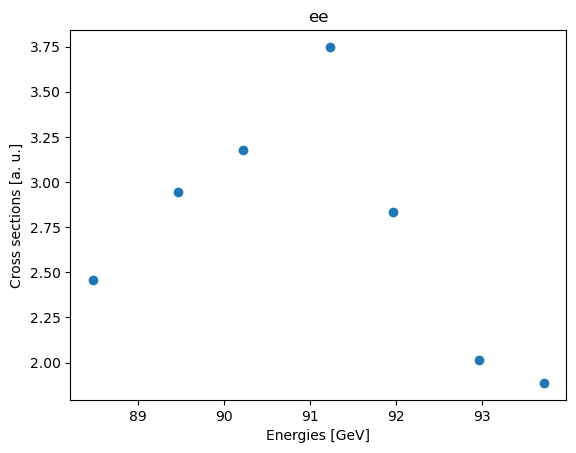

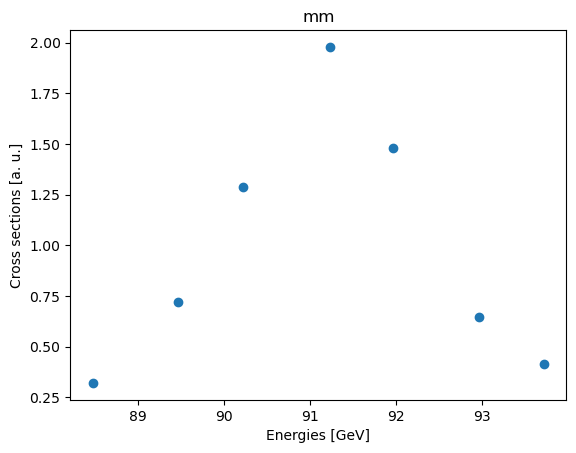

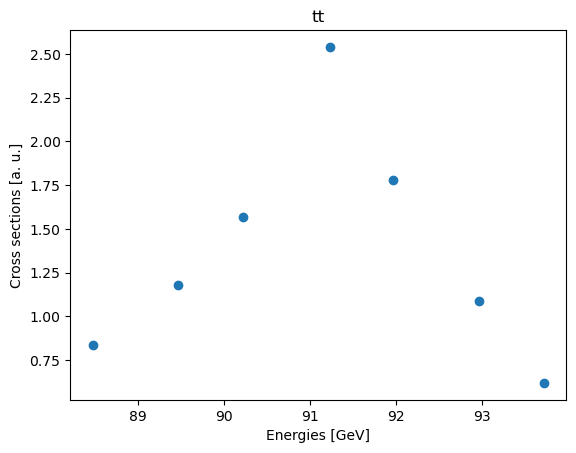

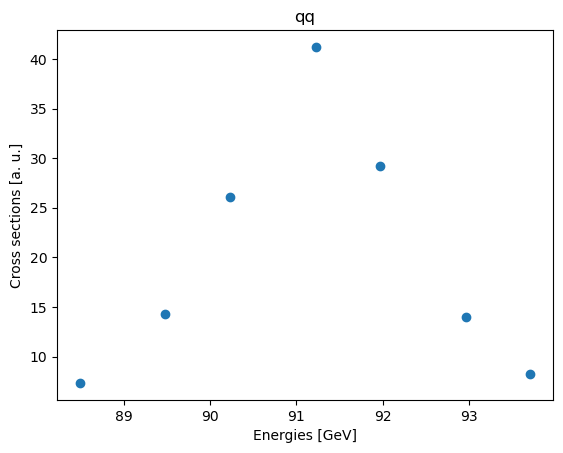

In [369]:
for i in range(4):
    plt.plot(energies, crossSections[i, :], "o")
    plt.title(fileNames[i])
    plt.xlabel("Energies [GeV]")
    plt.ylabel("Cross sections [a. u.]")
    plt.show()

## Part 3.4 - Fit a Breit-Wigner function to the cross sections

Once the cross sections have been calculated, the physical quantities of the Z0-boson can be retrieved by fitting the expected Breit-Wigner cross section to the data:

\begin{equation}
\frac{a}{\frac{4 (x-b)^2}{c^2} + \left(\frac{x}{b}\right)^2}
\end{equation}

### Questions

1. What physical characteristic of the Z0 does each of the free parameters, $a$, $b$ and $c$ correspond to?

### Exercises

3.4.1. Fit a Breit-Wigner function to each of the channels.

3.4.2. Plot the measured data (as in 3.3.2) together with the fitted function. Present the error in the fit function as a shaded area.

(The cells of 2.2. may be useful examples here :D)

In [370]:
def BreitWigner(x, a, b, c):
    return a / (4.0 * (x - [b])**2 / c**2 + (x / [b])**2)

[a. b. c] :  [41.11997857 91.19944331  2.52136066] +-  [0.93733033 0.0304352  0.08660346]


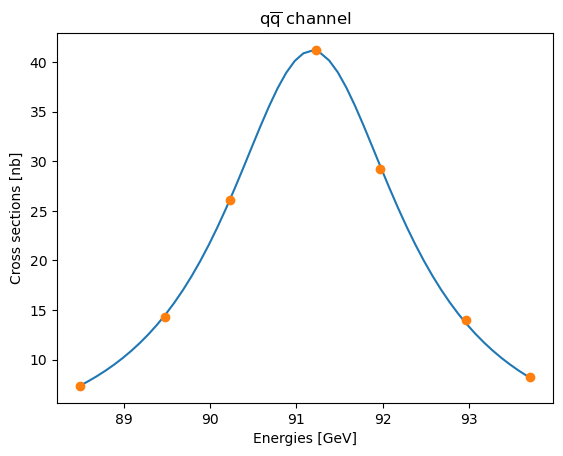

[a. b. c] :  [ 3.47574922 90.77887319  6.1547118 ] +-  [0.69267039 0.63936682 2.98796354]


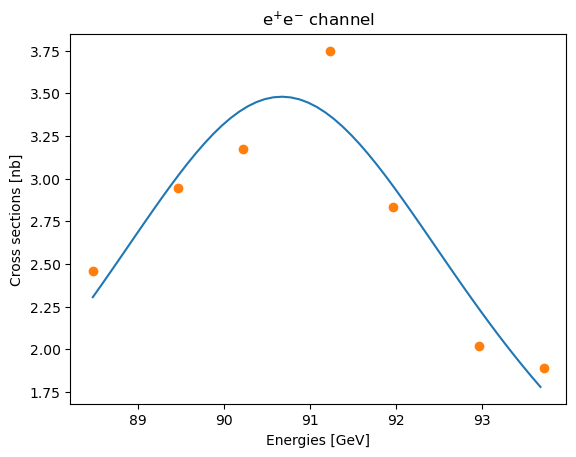

[a. b. c] :  [ 1.99870155 91.20827854  2.54839798] +-  [0.93122731 0.62928867 1.7955067 ]


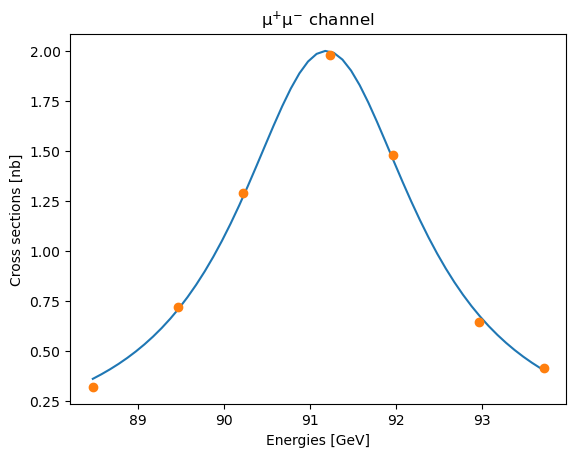

[a. b. c] :  [ 2.38665633 91.19216454  3.18210685] +-  [0.86566237 0.57871568 1.8598471 ]


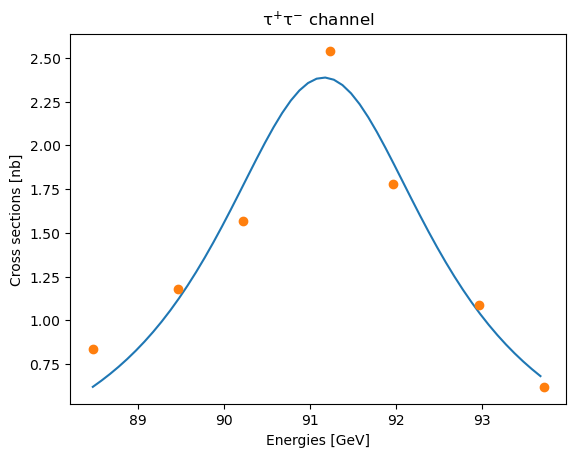

(array([ 2.38665633, 91.19216454,  3.18210685]),
 array([0.86566237, 0.57871568, 1.8598471 ]),
 -1)

In [380]:
# fit example

def fit(i, p0 = None, sigma = None):
    popt, pcov = curve_fit(BreitWigner, energies, crossSections[i, :], p0 = p0, sigma = sigma, absolute_sigma = True)
    psig = np.sqrt(np.diag(pcov))
    
    print("[a. b. c] : ", popt, "+- ", psig)
    
    xVals = np.arange(energies[0], energies[-1], 0.1)
    plt.plot(xVals, BreitWigner(xVals, *popt))

    if sigma is None:
        plt.plot(energies, crossSections[i, :], "o")
    else:
        plt.errorbar(energies, crossSections[i, :], yerr = sigma, fmt = "o")
    plt.title(titles[fileNames[i]])
    plt.xlabel("Energies [GeV]")
    plt.ylabel("Cross sections [nb]")

    if not sigma is None:
        plt.tight_layout()
        plt.savefig(f"{fileNames[i]} cross sections.pdf")
    plt.show()

    redXiSq = -1
    if not sigma is None:
        redXiSq = 1 / (len(energies) - 3) * np.sum( ( (crossSections[i, :] - BreitWigner(energies, *popt)) / sigma )**2 )
    
    return popt, psig, redXiSq

popt, _, _ = fit(3)
fit(0, popt)
fit(1, popt)
fit(2, popt)

## Part 3.5 - Calculate errors in the cross section data

In the previous part, the fit was done disregarding statistical uncertainties in the measured data. This means that different poins are considered equally into the fit, even tough they shouldn't. In this section we present the calculation of the errors in $\Delta \sigma_{i,k}$.

In order to calculate the final $\Delta \sigma_{i,k}$, we first need to evaluate the statistical uncertainties in each of the terms, i.e., $\Delta L_{k}$, $\Delta N^{j,k}_{\rm{det}}$ and $\Delta A_{i,j}^{-1}$.

*Luminosity*

The uncertainties in the luminosity, $\Delta L_{k}$ were given above.

*Number of measured events*

The uncertainties in the measured events is purely Poissonian, therefore: $\Delta N_{\rm{det}}^{j,k} = \sqrt{N_{\rm{det}}^{j,k}}$

*Acceptance matrix*

The uncertainties in the acceptance matrix are $\Delta A_{i,j} = \sqrt{A_{i,j} (1-A_{i,j})/10^5}$

*Inverted acceptance matrix*

The uncertainties in the INVERTED acceptance matrix are $\Delta A^{-1} = A^{-1} \Delta A A^{-1}$

Finally, via error propagation:

\begin{equation}
\sigma_{i,k} = \frac{\Sigma_j A_{i,j}^{-1} N_{\rm{det}}^{j,k}}{L_{k}}
\end{equation}

\begin{equation}
\implies \Delta \sigma_{i,k} = \sqrt{\Sigma_j \left(\Delta A^{-1}_{i,j} \frac{N_{\rm{det}}^{j,k}}{L_{k}}\right)^2 + \Sigma_j \left( \Delta N_{\rm{det}}^{j,k} \frac{A^{-1}_{i,j}}{L_{k}} \right)^2 + \Sigma_j \left( \Delta L_k \frac{A^{-1}_{i,j} N_{\rm{det}}^{j,k}}{L^2_k}\right)^2 }
\end{equation}

### Exercises

3.5.1. Calculate the statistical uncertainties on the cross sections for each energy and channel.

3.5.2. Plot the cross section showing the statistical uncertainties.

In [377]:
N_detSig = np.sqrt(N_det)
correctedAcceptanceMatrixSig = np.sqrt(correctedAcceptanceMatrix * (1 - correctedAcceptanceMatrix) / 1e5)
correctedAcceptanceMatrixInv = np.linalg.inv(correctedAcceptanceMatrix)
correctedAcceptanceMatrixInvSig = correctedAcceptanceMatrixInv @ correctedAcceptanceMatrixSig @ correctedAcceptanceMatrixInv

In [378]:
# [i, k]
crossSectionsSig = np.array([
    np.sqrt( np.sum( (correctedAcceptanceMatrixInvSig * N_det[k, :] / luminosities[k])**2 +
                    (N_detSig[k] * correctedAcceptanceMatrixInv / luminosities[k])**2 + 
                    (luminosities_error[k] * correctedAcceptanceMatrixInv * N_det[k] / luminosities[k]**2)**2, axis = 0) )
    for k in range(7)]).T
crossSectionsSig

array([[0.07293651, 0.08785488, 0.1016994 , 0.04075787, 0.07968511,
        0.0804599 , 0.06254837],
       [0.02024643, 0.03378306, 0.05157375, 0.02390615, 0.04884221,
        0.04046712, 0.02780601],
       [0.04858863, 0.06532186, 0.08891821, 0.04308771, 0.08287464,
        0.07670633, 0.04913572],
       [0.09550433, 0.15135959, 0.24842084, 0.12997437, 0.24421031,
        0.19976603, 0.1276269 ]])

## Part 3.6 - Fit of the data considering errors

Finally, we can now fit the data considering the errors in the data, as it should be.

### Exercises

3.6.1. Refit the data, now considering the statistical uncertainties.

3.6.2. Plot the data with errors and the fitted functions.

3.6.3. Calculate the $\chi^2/\rm{NDF}$ for each channel.

[a. b. c] :  [41.19212225 91.20399692  2.52139403] +-  [0.12775231 0.00641547 0.01241141]


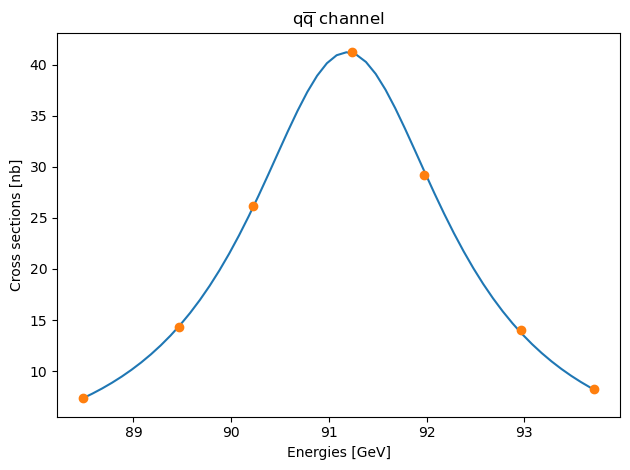

red xi^2 value: 1.8266437740728692
[a. b. c] :  [ 3.72030135 90.81485013  5.63086436] +-  [0.04196115 0.04236581 0.15388884]


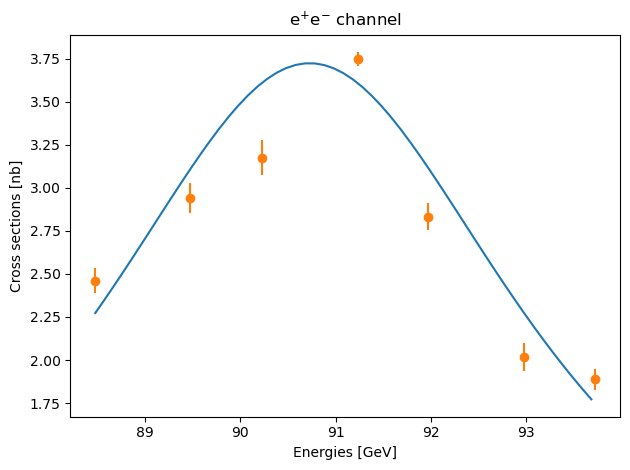

red xi^2 value: 17.005075333548323
[a. b. c] :  [ 1.98715038 91.21750901  2.52782805] +-  [0.02353244 0.02757486 0.05253039]


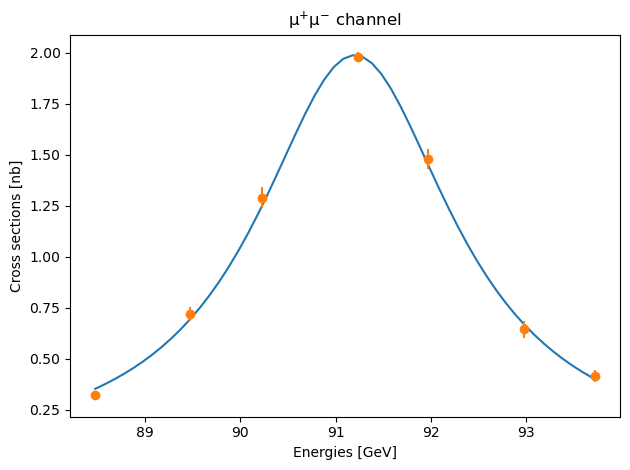

red xi^2 value: 1.2360559576899754
[a. b. c] :  [ 2.49060843 91.14233064  3.16372847] +-  [0.04249103 0.04099944 0.09572949]


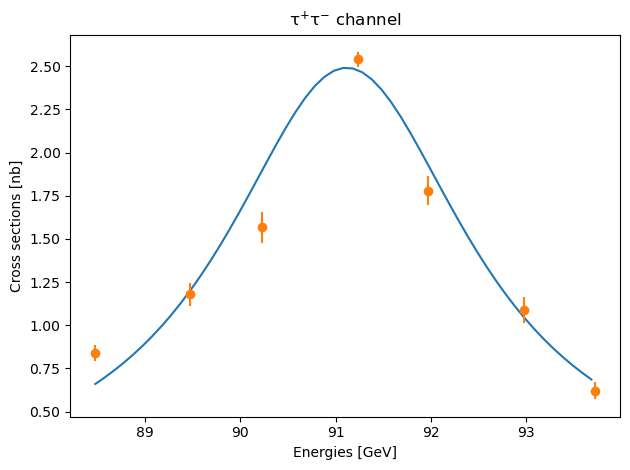

red xi^2 value: 8.449201507046556


In [381]:
popt = None
popts = []
psigs = []

order = np.array([3, 0, 1, 2])
for i in order:
    popt, psig, xi = fit(i, popt, crossSectionsSig[i])
    
    popts.append(popt)
    psigs.append(psig)
    
    print("red xi^2 value:", xi)

popts = np.array(popts)
psigs = np.array(psigs)

invOrder = np.empty_like(order)
invOrder[order] = np.arange(order.size)

# popts, psigs ~ ["ee", "mm", "tt", "qq"]
popts = popts[invOrder]
psigs = psigs[invOrder]

In [382]:
avgMZ0 = np.sum(popts[:, 1] / psigs[:, 1]**2) / np.sum(1 / psigs[:, 1]**2)
avgMZ0Sig = np.sqrt(1 / np.sum(1 / psigs[:, 1]**2))

avgGammaZ = np.sum(popts[:, 2] / psigs[:, 2]**2) / np.sum(1 / psigs[:, 2]**2)
avgGammaZSig = np.sqrt(1 / np.sum(1 / psigs[:, 2]**2))

tau = constants.hbar / (avgGamma * 1e9 * constants.elementary_charge)
tauSig = constants.hbar / (avgGamma**2 * 1e9 * constants.elementary_charge) * avgGammaSig

print(f"M-Z0 = {avgMZ0:.5f} +- {avgMZ0Sig:.5f}")
print(f"Gamma-Z0 = {avgGammaZ:.5f} +- {avgGammaZSig:.5f}")
print(f"Tau = {tau:.5e} +- {tauSig:.5e}")

M-Z0 = 91.19519 +- 0.00611
Gamma-Z0 = 2.55048 +- 0.01195
Tau = 2.58074e-25 +- 1.20894e-27


In [383]:
# gamma_e^2 = cross_peak_e / (12 pi) MZ0^2 gamma_Z^2
gammaE = np.sqrt(popts[0, 0] / (12 * np.pi) * avgMZ0**2 * avgGammaZ**2)
gammaESig = 1 / gammaE * np.sqrt( (psigs[0, 0] / (12 * np.pi) * avgMZ0**2 * avgGammaZ**2)**2 +
                                (avgMZ0Sig * popts[0, 0] / (12 * np.pi) * 2 * avgMZ0 * avgGammaZ**2)**2 + 
                                (avgGammaZSig * psigs[0, 0] / (12 * np.pi) * avgMZ0**2 * 2 * avgGammaZ)**2 )

print(f"Gamma_e = {gammaE} +- {gammaESig}")

gamma = lambda crossPeak : crossPeak / (12 * np.pi) * avgMZ0**2 * avgGammaZ**2 / gammaE
gammaSig = lambda crossPeak, crossPeakSig : 1 / (12 * np.pi) * np.sqrt( 
    (crossPeakSig * avgMZ0**2 * avgGammaZ**2 / gammaE)**2 +
    (avgMZ0Sig * crossPeak * 2 * avgMZ0 * avgGammaZ**2 / gammaE)**2 +
    (avgGammaZSig * crossPeak * avgMZ0**2 * 2 * avgGammaZ / gammaE)**2 + 
    (gammaESig * crossPeak * avgMZ0**2 * avgGammaZ**2 / gammaE**2)**2)


gammaMM = gamma(popts[1, 0])
gammaMMSig = gammaSig(popts[1, 0], psigs[1, 0])
print(f"gammaMM = {gammaMM} +- {gammaMMSig}")

gammaTT = gamma(popts[2, 0])
gammaTTSig = gammaSig(popts[2, 0], psigs[2, 0])
print(f"gammaTT = {gammaTT} +- {gammaTTSig}")

gammaQQ = gamma(popts[3, 0])
gammaQQSig = gammaSig(popts[3, 0], psigs[3, 0])
print(f"gammaQQ = {gammaQQ} +- {gammaQQSig}")

Gamma_e = 73.0662025582036 +- 0.8242056133524176
gammaMM = 39.02735790480345 +- 0.7356216005118996
gammaTT = 48.91520421533185 +- 1.1004295282380996
gammaQQ = 809.0075677876133 +- 12.125893528958407


### Questions

1. What does the $\chi^2/\rm{NDF}$ mean?

2. What range of $\chi^2/\rm{NDF}$ denotes a good fit? What happens outside of this range?

3. How good was the fit you just got?
   qq & mm are good, others are meh

## E2

In [384]:
# N_v Gamma_v = Gamma_Z - Gamma_ee,mm,tt,qq
# assume Gamma_unknown = 0
NGammaV = avgGammaZ * 1e3 + 2 * ( - gammaE - gammaMM - gammaTT - gammaQQ)
N = NGammaV / 167.6
N

3.6422586384346043

In [385]:
gammaQQ

809.0075677876133

In [341]:
2 * 299 + 3 * 378

1732